<p style="text-align: center;" ><font size="+3"><u><b>Laboratory 4 Part 2: System Identification and Optimization</u></b></p>

<p style="text-align: left;" ><font size="+1"><b>Group #: ___________   Team Members: _______________  </b></p>

<p style="text-align: left;" ><font size="+1"><b>Optimization Basics</b></p>

<div class="alert alert-block alert-warning">
<font color=black>

When you define an optimization problem you must consider three main elements: <br/>
1) the **optimization parameters**: the variables you are trying to find, <br/>
2) the **objective function**: a function (of the optimization parameters) of which you are trying to find minimum (or maximum); this is often a fitting function (e.g. a measure of error in a data fit), and <br/>
3) the **optimization algorithm/optimizer** – which is the particular algorithm we are using to find the optimum. Mathematically, we may write the optimization as
\begin{equation}
x^{*} = \underset{x}{\operatorname{argmin}}  f(x)
\end{equation} 
    
where $x$ is a vector of optimization parameters and $f(x)$ is the objective function. The minimization is defined implicitly and needs to be solved using some algorithm. <br/>
    
An example of how to code a simple optimization problem in Python is provided on Blackboard (`Lab4 Optimization Example.ipynb`). Run the code and understand the output, what the code is doing, and how to formulate a general optimization problem with the help of descriptions provided below.
</font> 
</div>

<p style="text-align: left;" ><font size="+1"><b>System Identification in Simulated Data</b></p>

<div class="alert alert-block alert-warning">
<font color=black>

We are going to use the same kind of procedure as outlined above to find out certain parameters in a physical microscope system. To do this we need a functional form of our data simulator. Specifically, you need to convert the simulation code you wrote from Part 1 of this lab to a function called `make_psf`. The inputs to the function are radius of the exit pupil (`r`), coefficients to the Zernike polynomials (`coefs`) that define any system aberrations, the corresponding mode indices of the Zernike polynomials (`mode_indices`), and size of the PSF you want to make (`nxy`). The output of the function should be a simulated PSF. For example, you should be able to execute the following command:
    
`def make_psf(r, coefs, mode_indices, nxy):` <br/>
`    # code block computing psf`<br/>
`    return psf`<br/>

Call the function and confirm you get the same results as before. <br/>
    
Next, we’ll write an objective function. Create a function in Python called `objfunc`. The inputs to the function are:
1) the optimization parameters in vector form (`xv`). Note that all the parameters need to be in a single vector, and the vector needs to be the first argument to the objective function
2) the PSF you want to fit to (a simulated PSF in this case, or the measured PSF in real data, `mpsf`), and 
3) the mode indices of the Zernike polynomials (`mode_indices`) <br/>
    
The objective function to the optimization is sum of squared error between the estimated PSF and PSF you want to fit to (`mpsf`). In a separate script, write the objective function with the following syntax:

`def objfunc(xv, mpsf, mode_indices):` <br/>
`    # code block computing the value of the objective function` <br/>
`    return val` <br/>

Note that our model did not account for the magnitude of the PSF. Before calculating the sum of squared error, normalize both PSFs to the same scale, e.g., between 0 and 1. <br/>

In your optimization routine, similar to the example in `Lab4 Optimization Example.ipynb`, display a figure containing `mpsf`, the estimated PSF (from `make_psf`), and the absolute difference between the two with a colorbar. This will allow you to see how the optimization is doing in real time. <br/><br/>

</font> 
</div>

In [1]:
import numpy as np
from numpy.fft import fftshift, fftfreq, ifftshift, fft2, ifft2
import matplotlib.pyplot as plt
import scipy
from scipy.special import gamma
import cma

In [7]:
def make_star(x, y, stype='bin', cycles=36):
    [X,Y] = np.meshgrid(x, y)
    phy = np.arctan2(Y,X) * cycles  #phase at each pixel
    pint = np.cos(phy)  #relative intensity
    if 'bin' in stype:
        star = np.zeros_like(X, dtype=np.uint8)
        star[pint>=0] = 255
    elif 'sin' in stype:
        star = ((pint+1)*127.5).astype(np.uint8)
    mask1 = (X**2+Y**2) > (x.max()/20)**2
    mask2 = (X**2+Y**2) < (x.max())**2
    star = star.astype(np.double) * mask1.astype(np.double) * mask2.astype(np.double)
    return star/star.max()

def zrf(n, m, r):
    R = 0
    for s in range((n-m)//2+1):
        num = (-1)**s * gamma(n-s+1)
        denom = gamma(s+1) * gamma((n+m)/2-s+1) * gamma((n-m)/2-s+1)
        R = R + num / denom * r**(n-2*s)
    return R

def zernike(fx, fy, i, wz):
    FX, FY = np.meshgrid(fx, fy)
    r = np.sqrt(FX**2 + FY**2)
    theta = np.arctan2(FY, FX)
    
    if len(i) != len(wz):
        raise ValueError('zernike:Matchinglength','i and wz must be the same length.')
    
    zernike_index = np.load('Lab4/zernike_index.npy')
    Z_sum = 0
    for ind in range(len(i)):
        n = zernike_index[i[ind]-1, 0]
        m = zernike_index[i[ind]-1, 1]
        if m == 0:
            Z = np.sqrt(n+1)*zrf(n,0,r)
        else:
            if i[ind] % 2 == 0:  # i is even
                Z = np.sqrt(2*(n+1))*zrf(n,m,r) * np.cos(m*theta)
            else: # i is odd
                Z = np.sqrt(2*(n+1))*zrf(n,m,r) * np.sin(m*theta)
        Z_sum += wz[ind]*Z

    unit_circle_mask = (FX**2 + FY**2 <= 1).astype(np.float64)
    Z_sum *= unit_circle_mask
    return Z_sum

In [8]:
def setup_grids(N=1001, dx=5.3e-6):
    x = np.linspace(-((N-1)/2)*dx, ((N-1)/2)*dx, N)
    y = np.linspace(-((N-1)/2)*dx, ((N-1)/2)*dx, N)
    fx = fftshift(fftfreq(N, dx))  # convert to microns
    fy = fftshift(fftfreq(N, dx))  # convert to microns
    
    return x, y, fx, fy

def compute_PSF_OTF_aberrations(fx, fy, mode_indices, coefs, lambd=540e-9, zi=300e-3, r=2e-3):
    z_sum = zernike(-lambd * zi * fx / r, -lambd * zi * fy / r, mode_indices, coefs)
    phase = np.exp(-1j * 2 * np.pi * z_sum)
    
    FX, FY = np.meshgrid(-lambd * zi * fx, -lambd * zi * fy)
    H = (FX**2 + FY**2) < r**2
    H_with_aberration = H * phase
    
    h = fftshift(ifft2(ifftshift(H_with_aberration)))
    psf = np.abs(h)**2
    psf /= np.max(psf) 

    OTF = fftshift(fft2(ifftshift(psf))) / np.sum(psf)

    return psf, OTF, H_with_aberration

def convolve_fft(image, psf):
    image_fft = fft2(ifftshift(image))
    psf_fft = fft2(ifftshift(psf))
    blurred = np.real(fftshift(ifft2(image_fft * psf_fft)))
    return blurred/np.max(blurred)

def plot_aberration_analysis(psf, OTF, star_blurred, title, dx=5.3e-6, zoom_size=201, N=1001):

    center = N // 2
    half_zoom = zoom_size // 2
    zoom_slice = slice(center - half_zoom, center + half_zoom + 1)
    psf_zoomed = psf[zoom_slice, zoom_slice]
    log10_psf_zoomed = np.log10(psf_zoomed + 1e-12) 
    
    dx_um = dx * 1e6 # convert to microns
    extent = [-half_zoom*dx_um, half_zoom*dx_um, -half_zoom*dx_um, half_zoom*dx_um]
    freq_extent = [-1/(2*dx_um), 1/(2*dx_um), -1/(2*dx_um), 1/(2*dx_um)]
    
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))

    im0 = axs[0, 0].imshow(psf_zoomed, cmap='jet', extent=extent)
    axs[0, 0].set_title(f'PSF with {title}')
    axs[0, 0].set_xlabel('X (μm)')
    axs[0, 0].set_ylabel('Y (μm)')
    fig.colorbar(im0, ax=axs[0, 0], label='Intensity')
    
    im1 = axs[0, 1].imshow(log10_psf_zoomed, cmap='jet', extent=extent, vmin=-12, vmax=0)
    axs[0, 1].set_title(f'Log10 PSF with {title}')
    axs[0, 1].set_xlabel('X (μm)')
    axs[0, 1].set_ylabel('Y (μm)')
    fig.colorbar(im1, ax=axs[0, 1], label='Log Intensity')
    
    im2 = axs[1, 0].imshow(np.real(OTF), cmap='jet', extent=freq_extent)
    axs[1, 0].set_title('Real Values of OTF')
    axs[1, 0].set_xlabel('Frequency X (1/m)')
    axs[1, 0].set_ylabel('Frequency Y (1/m)')
    fig.colorbar(im2, ax=axs[1, 0], label='Real Value')
    
    im3 = axs[1, 1].imshow(np.abs(OTF), cmap='jet', extent=freq_extent)
    axs[1, 1].set_title('Absolute Values of OTF')
    axs[1, 1].set_xlabel('Frequency X (1/m)')
    axs[1, 1].set_ylabel('Frequency Y (1/m)')
    fig.colorbar(im3, ax=axs[1, 1], label='Magnitude')
    
    im4 = axs[0, 2].imshow(star_blurred, cmap='gray')
    axs[0, 2].set_title(f'Star Pattern with {title}')
    axs[0, 2].set_xlabel('X (μm)')
    axs[0, 2].set_ylabel('Y (μm)')
    fig.colorbar(im4, ax=axs[0, 2], label='Intensity')

    center_y = OTF.shape[0] // 2
    x_axis = np.arange(-OTF.shape[1]//2, OTF.shape[1]//2) / OTF.shape[1]
    axs[1, 2].plot(x_axis, np.real(OTF[center_y, :]))
    axs[1, 2].set_title('1D Profile of Real OTF along x-axis')
    axs[1, 2].set_xlabel('Normalized Frequency')
    axs[1, 2].set_ylabel('Real Value')
    axs[1, 2].grid(True)
    
    plt.tight_layout()
    return fig, axs

def analyze_aberration(mode_indices, coefs, title, star, x, y, fx, fy, lambd=540e-9, zi=300e-3, r=2e-3, N=1001, zoom_size=201):
    psf, OTF, _ = compute_PSF_OTF_aberrations(fx, fy, mode_indices, coefs, lambd, zi, r)
    
    star_blurred = convolve_fft(star, psf)
    
    fig, axs = plot_aberration_analysis(psf, OTF, star_blurred, title, dx=5.3e-6, zoom_size=zoom_size, N=N)
    
    return psf, OTF, star_blurred, fig

<div class="alert alert-block alert-success">
<font color=black>

1. In summary, your objective function should contain the following three parts:

- Parse `xv`
- Generate model prediction of PSF using parsed `xv` 
- Normalize `mpsf` and the PSF from 2) and calculate and return the sum of squared error between the two (e.g. over all pixels)

Show your code below:

</font> 
</div>

In [20]:
def make_psf(r, coefs, mode_indices, nxy, dx=3.45e-6):
    lambd = 540e-9
    zi = 300e-3 

    #setup grid
    x, y, fx, fy = setup_grids(N=nxy, dx=dx)
    
    z_sum = zernike(-lambd * zi * fx / r, -lambd * zi * fy / r, mode_indices, coefs)
    phase = np.exp(-1j * 2 * np.pi * z_sum)

    FX, FY = np.meshgrid(-lambd * zi * fx, -lambd * zi * fx)
    H = (FX**2 + FY**2) < r**2
    H_with_aberration = H * phase
    
    h = fftshift(ifft2(ifftshift(H_with_aberration)))
    
    psf = np.abs(h)**2
    psf /= np.sum(psf)
    
    return psf

def objfunc(xv, mpsf, mode_indices, r=2e-3, zoom_half_size=100):
    coefs = xv
    nxy = mpsf.shape[0]  # full size, e.g., 1001
    
    est_psf = make_psf(r, coefs, mode_indices, nxy)
    
    # Zoom into center 200x200
    center = nxy // 2
    zoom_slice = slice(center - zoom_half_size, center + zoom_half_size)
    
    mpsf_zoomed = mpsf[zoom_slice, zoom_slice]
    est_psf_zoomed = est_psf[zoom_slice, zoom_slice]
    
    # Normalize *after* zooming
    mpsf_norm = mpsf_zoomed / np.sum(mpsf_zoomed)
    est_psf_norm = est_psf_zoomed / np.sum(est_psf_zoomed)
    
    # Compute squared difference
    val = np.sum((mpsf_norm - est_psf_norm)**2)
    
    return val

def plot_psf_comparison(target_psf, optimized_psf, extent=None):


    half_zoom = 100
    dx = 3.45e-6  # pixel size in meters
    center = target_psf.shape[0] // 2
    zoom_slice = slice(center - half_zoom, center + half_zoom)

    # Crop PSFs
    target_psf_zoomed = target_psf[zoom_slice, zoom_slice]
    optimized_psf_zoomed = optimized_psf[zoom_slice, zoom_slice]
    
    # Extent in microns
    dx_um = dx * 1e6  # meters to microns
    extent = [-half_zoom * dx_um, half_zoom * dx_um, -half_zoom * dx_um, half_zoom * dx_um]

    # X, Y grids for surface plots
    x = np.linspace(extent[0], extent[1], target_psf_zoomed.shape[0])
    y = np.linspace(extent[2], extent[3], target_psf_zoomed.shape[1])
    X, Y = np.meshgrid(x, y)

    # Create the figure and axes for plotting
    fig = plt.figure(figsize=(15, 10))

    # Subplot 1: Target PSF (2D heatmap)
    ax1 = fig.add_subplot(2, 3, 1)
    im1 = ax1.imshow(target_psf_zoomed, cmap='jet', extent=extent)
    ax1.set_title('Target PSF (2D)')
    ax1.set_xlabel('X (μm)')
    ax1.set_ylabel('Y (μm)')
    fig.colorbar(im1, ax=ax1)

    # Subplot 2: Optimized PSF (2D heatmap)
    ax2 = fig.add_subplot(2, 3, 2)
    im2 = ax2.imshow(optimized_psf_zoomed, cmap='jet', extent=extent)
    ax2.set_title('Optimized PSF (2D)')
    ax2.set_xlabel('X (μm)')
    ax2.set_ylabel('Y (μm)')
    fig.colorbar(im2, ax=ax2)

    # Subplot 3: Difference (2D heatmap)
    ax3 = fig.add_subplot(2, 3, 3)
    diff = np.abs(target_psf_zoomed - optimized_psf_zoomed)
    im3 = ax3.imshow(diff, cmap='jet', extent=extent)
    ax3.set_title('Difference (2D)')
    ax3.set_xlabel('X (μm)')
    ax3.set_ylabel('Y (μm)')
    fig.colorbar(im3, ax=ax3)

    # Subplot 4: Target PSF (3D surface plot)
    ax4 = fig.add_subplot(2, 3, 4, projection='3d')
    ax4.plot_surface(X, Y, target_psf_zoomed, cmap='jet', edgecolor='none')
    ax4.set_title('Target PSF (Surface)')
    ax4.set_xlabel('X (μm)')
    ax4.set_ylabel('Y (μm)')
    ax4.set_zlabel('Intensity')

    # Subplot 5: Optimized PSF (3D surface plot)
    ax5 = fig.add_subplot(2, 3, 5, projection='3d')
    ax5.plot_surface(X, Y, optimized_psf_zoomed, cmap='jet', edgecolor='none')
    ax5.set_title('Optimized PSF (Surface)')
    ax5.set_xlabel('X (μm)')
    ax5.set_ylabel('Y (μm)')
    ax5.set_zlabel('Intensity')

    # Subplot 6: Difference (3D surface plot)
    ax6 = fig.add_subplot(2, 3, 6, projection='3d')
    ax6.plot_surface(X, Y, diff, cmap='jet', edgecolor='none')
    ax6.set_title('Difference (Surface)')
    ax6.set_xlabel('X (μm)')
    ax6.set_ylabel('Y (μm)')
    ax6.set_zlabel('Difference')

    plt.tight_layout()
    plt.show()

def plot_pupil_phase(mode_indices, coefs, r, lambd=540e-9, zi=300e-3, nxy=1001, dx=3.45e-6, title='Pupil Phase Function'):
    
    mm_per_pixel = 6.260371216900035e-07/1000
    extent = [-nxy/2*dx/mm_per_pixel, nxy/2*dx/mm_per_pixel, -nxy/2*dx/mm_per_pixel, nxy/2*dx/mm_per_pixel]

    x, y, fx, fy = setup_grids(N=nxy, dx=dx)
    z_sum = zernike(-lambd*zi*fx/r, -lambd*zi*fy/r, mode_indices, coefs)
    plt.figure()
    plt.imshow(z_sum, cmap = 'jet', extent=extent)
    plt.xlabel('X (mm)')
    plt.ylabel('Y (mm)')
    plt.colorbar(label = 'Intensity')
    plt.title(title)

<div class="alert alert-block alert-success">
<font color=black>

2. Use your `make_psf` function to generate a PSF from part 1 of this lab, for example: 
    
`mode_indices = [7, 8]`<br/>
`coefs = [0.05, -0.2]`<br/>

Assume that you know the Zernike modes but do not know the coefficients, use the optimization routine to see if you can recover the coefficients.
    
A few tricks to help the optimization:
- Have good initial guesses (close to the final solution) are important
- When computing the objective function, you can zoom in to a region of interest containing the PSF instead of calculating sum of squared error over the entire image <br/>
- Show an image of both PSFs and their absolute difference

</font> 
</div>

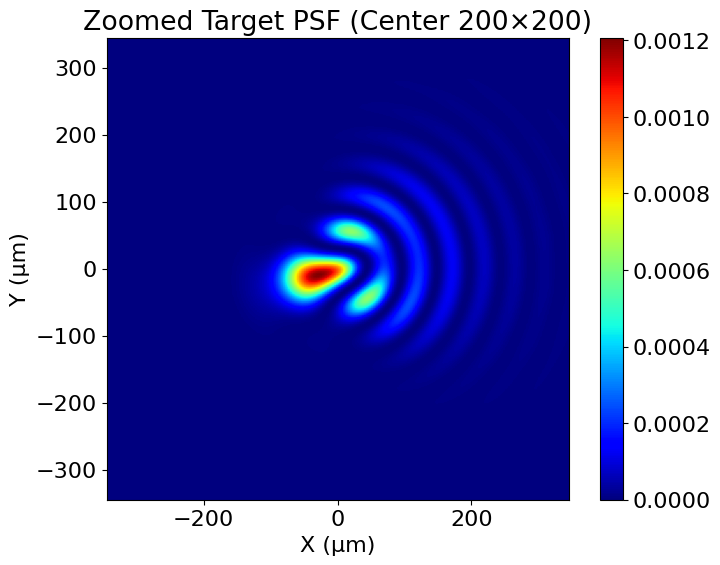

In [77]:
r = 2e-3
nxy = 1001
mode_indices = [7, 8]
true_coefs = [0.05, -0.2]
dx = 3.45e-6  # meters

target_psf = make_psf(r, true_coefs, mode_indices, nxy, dx=dx)

half_zoom = 100  # Half of 200
center = target_psf.shape[0] // 2

zoom_slice = slice(center - half_zoom, center + half_zoom)
target_psf_zoomed = target_psf[zoom_slice, zoom_slice]

# Set correct extent based on zoomed region
dx_um = dx * 1e6  # meters to microns
size_um = target_psf_zoomed.shape[0] * dx_um  # 200 pixels × microns/pixel
extent = [-size_um/2, size_um/2, -size_um/2, size_um/2]

plt.figure(figsize=(8, 6))
plt.imshow(target_psf_zoomed, cmap='jet', extent=extent)
plt.title('Zoomed Target PSF (Center 200×200)')
plt.xlabel('X (μm)')
plt.ylabel('Y (μm)')
plt.colorbar()
plt.show()


<div class="alert alert-block alert-success">
<font color=black>

3. Show the plot of the simulated PSF from `make_psf` with the Zernike modes and coefficients you used. What is the coefficient you obtained from the optimization? What does the optimized or estimated PSF look like?

</font> 
</div>

(7_w,15)-aCMA-ES (mu_w=4.5,w_1=34%) in dimension 2 (seed=855051, Sun Apr 27 23:10:39 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     15 6.094217434627000e-06 1.0e+00 5.47e-02  5e-02  6e-02 0:01.4
    2     30 3.165419113713818e-05 1.3e+00 5.83e-02  5e-02  5e-02 0:02.8
    3     45 1.339438910868928e-06 1.1e+00 4.42e-02  3e-02  3e-02 0:04.3

Optimization Results:
True coefficients: [0.05, -0.2]
Initial guess: [0.03, -0.15]
Optimized coefficients: [ 0.05628688 -0.20308059]
Final objective function value: 1.2423802960197793e-06
Stopping criterion: {}


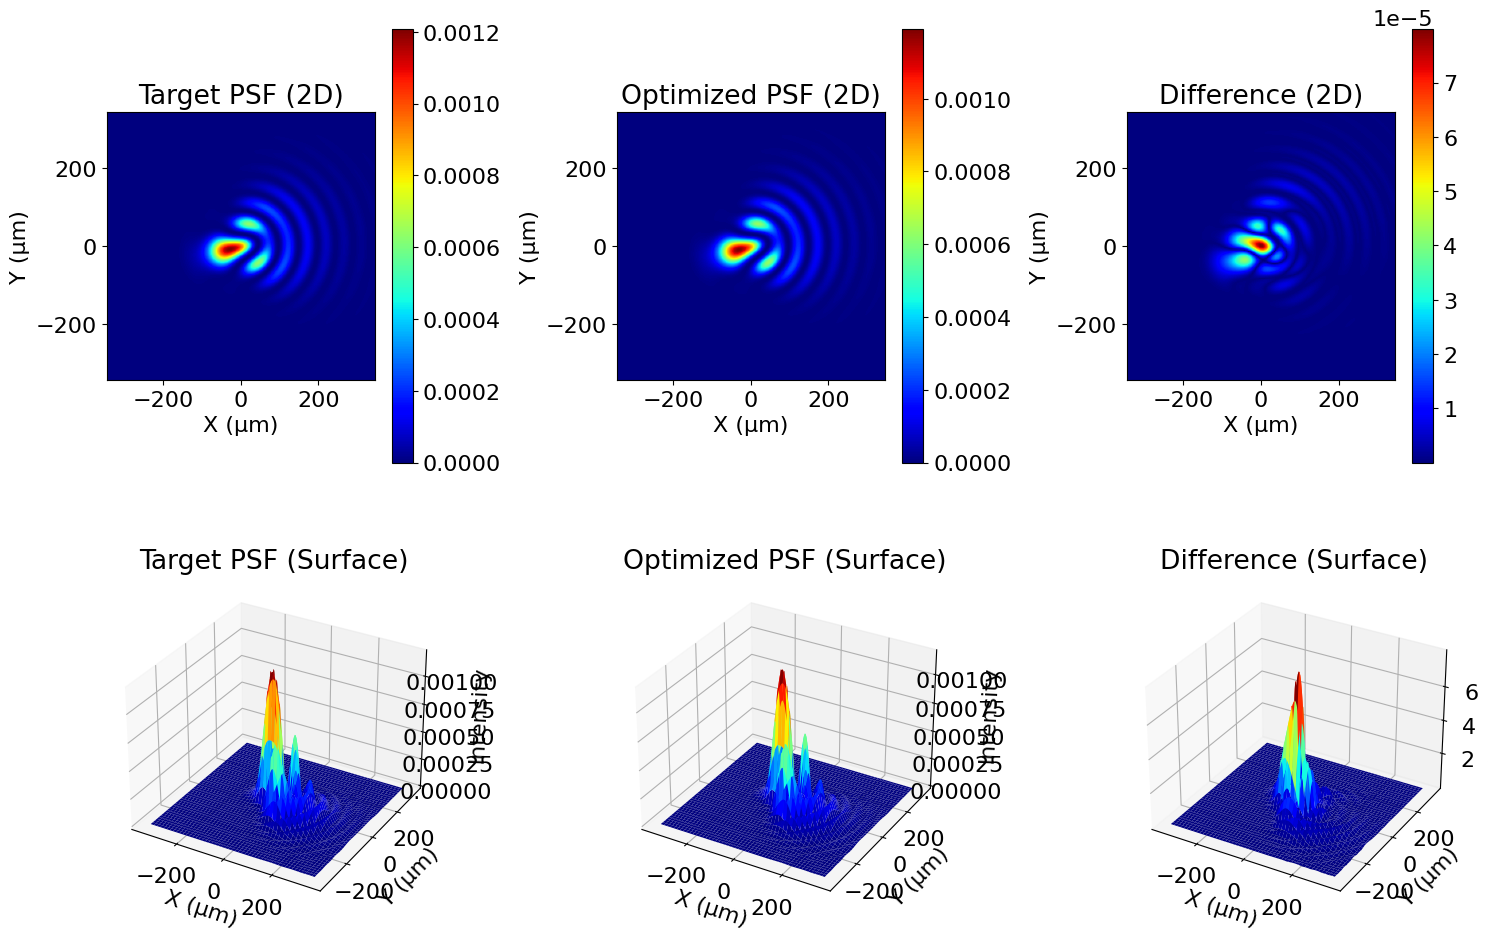

In [78]:
x0 = [0.03, -0.15]

sigma0 = 0.05  # Initial step size
popsize = 15   # Population size
opts = {
    'tolfun': 1e-8,  # Function value tolerance
    'tolx': 1e-8,    # Parameter tolerance
    'verb_disp': 10,  # Display interval
    'popsize': popsize,
}

es = cma.CMAEvolutionStrategy(x0, sigma0, opts)

fit = np.empty(popsize)
iteration = 0
max_iterations = 5

while not es.stop() and iteration < max_iterations:
    iteration += 1
    solutions = es.ask()
    
    for i, soln in enumerate(solutions):
        fit[i] = objfunc(soln, target_psf, mode_indices, r)
    
    es.tell(solutions, fit)
    es.disp(10)

xopt = es.result[0]
objfuncopt = es.result[1]

print("\nOptimization Results:")
print(f"True coefficients: {true_coefs}")
print(f"Initial guess: {x0}")
print(f"Optimized coefficients: {xopt}")
print(f"Final objective function value: {objfuncopt}")
print(f"Stopping criterion: {es.stop()}")

# Generate the optimized PSF
optimized_psf = make_psf(r, xopt, mode_indices, nxy)

plot_psf_comparison(target_psf, optimized_psf, extent=extent)

Parameters: [y_coma, x_coma]

True coefficients: [0.05, -0.2]
Initial guess: [0.03, -0.15]
Optimized coefficients: [0.05628688, -0.20308059]

The optimized PSF looks almost exactly like the target PSF. The difference image has extremely low intensity (on the scale of 10^-5) meaning the optimization was successful.

<p style="text-align: left;" ><font size="+1"><b>System Identification in Real Data</b></p>

<div class="alert alert-block alert-warning">
<font color=black>
Real data are not as “clean” as simulated data. There are noise, detector non-idealities, and other aberrations we might not be modeling. Let us first get our model to be as close to the real system as possible.
</font> 
</div>

In [31]:
import os
import sys
sys.path.insert(0,r'BaITools')
sys.path.insert(0,r'dlls')

import numpy as np
from time import sleep
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import cv2
plt.rcParams['font.size'] = 16
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from zelux import ZeluxCamera as Camera

ModuleNotFoundError: No module named 'zelux'

In [6]:
print('Camera initialized as c')
c = Camera()
c.open()

c.get_properties()
c.set_exposure(10)
c.get_exposure()
c.set_framerate(2)
c.get_framerate()



c.set_exposure(30)

Camera initialized as c
Camera Model 	 Thorlabs CS165MU
Pixel Size 	 3.45  microns
Image size 	 [1440, 1080]
Exposure 	 28.72  ms
Exposure Range 	 [0.06, 26843.42]  ms
Framerate 	 18.0
Frame Range 	 [0.9, 18.0]


In [38]:
def average_images(num_images):
    c.set_exposure(1000)
    image_10bit_stack = []
    for i in range(num_images):
        image_10bit_stack.append(c.capture().copy())
        if (i+1) % 10 == 0:
            print("image number taken:", i+1)
    average_image_10bit = np.mean(image_10bit_stack, axis=0)

    return average_image_10bit

def capture_image(save_name="False"):
    c.set_exposure(1000)
    image_10bit = c.capture().copy()
    x1,y1,x2,y2 = 625, 375, 825, 575
    cropped_image_10bit = image_10bit[y1:y2, x1:x2]

    fig, axes = plt.subplots(1, 2, figsize=(18, 5))

    im0 = axes[0].imshow(image_10bit, origin='lower', cmap='jet')
    axes[0].set_title(f"Original Image")
    axes[0].set_xlabel("X")
    axes[0].set_ylabel("Y")
    fig.colorbar(im0, ax=axes[0], label='Magnitude')

    im1 = axes[1].imshow(cropped_image_10bit, origin='lower', cmap='jet')
    axes[1].set_title(f"Cropped Image")
    axes[1].set_xlabel("X")
    axes[1].set_ylabel("Y")
    fig.colorbar(im1, ax=axes[1], label='Magnitude')

    plt.show()

    return image_10bit, cropped_image_10bit

def continuous_capture_jet(save_name="saved_image.png"):
    c.set_exposure(1000)
    while True:
        cv2.imshow('Camera', cv2.applyColorMap(cv2.normalize(c.capture().copy(), None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U), cv2.COLORMAP_JET)) #show 8 bit image
        if cv2.waitKey(30) & 0xFF == ord('s'):
            image = c.capture().copy()
            fig, ax = plt.subplots(1, figsize=(12, 5))
            x = ax.imshow(image, cmap='jet')
            fig.colorbar(x, ax=ax)
            ax.set_xlabel('X Axis pixels')
            ax.set_ylabel('Y Axis pixels')
            plt.savefig(save_name)
        if cv2.waitKey(30) & 0xFF == ord('q'):
            break
    cv2.destroyAllWindows()
    return image

def continuous_capture(save_name="saved_image.png"):
    while True:
        cv2.imshow('Camera', cv2.normalize(c.capture().copy(), None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)) #show 8 bit image
        if cv2.waitKey(30) & 0xFF == ord('s'):
            image = c.capture().copy()
            fig, ax = plt.subplots(1, figsize=(12, 5))
            x = ax.imshow(image, cmap='jet')
            fig.colorbar(x, ax=ax)
            ax.set_xlabel('X Axis pixels')
            ax.set_ylabel('Y Axis pixels')
            plt.savefig(save_name)
        if cv2.waitKey(30) & 0xFF == ord('q'):
            break
    cv2.destroyAllWindows()
    return image

def get_magnification():
    image_10bit = continuous_capture()

    %matplotlib widget

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_axes([0.1, 0.3, 0.6, 0.6])

    ax_divider = make_axes_locatable(ax)
    cax = ax_divider.append_axes("right", size="7%", pad="2%")

    im = ax.imshow(image_10bit, cmap='gray')
    cb = fig.colorbar(im, cax=cax)

    hfig = display(fig, display_id=True)
    plt.show()

def calculate_magnification(x1, y1, x2, y2, grid_size=100e-6, camera_size = 3.45e-6):
    d_squared = (x1-x2)**2 + (y1-y2)**2
    d = np.sqrt(d_squared) #number of pixels between grid_size um

    pixel_size_object = grid_size / d
    print('Pixel size of camera:', camera_size)
    print('Pixel size in object plane:', pixel_size_object)

    magnification = camera_size / pixel_size_object
    print('Magnification:', magnification)

    return magnification, pixel_size_object

def calculate_objectsamplingfrequency(pixel_size_object):
    object_sampling_frequency = 1 / pixel_size_object # in 1 / m
    object_sampling_frequency_mm = object_sampling_frequency / 1000
    print('Object sampling frequency in mm:', object_sampling_frequency_mm)
    return object_sampling_frequency

def show_image_fourier(image_10bit, name=""):
    D_shifted = ifftshift(image_10bit)
    D_fourier = fft2(D_shifted)
    D_fourier_shifted = fftshift(D_fourier)

    D_fourier_magnitude = np.abs(D_fourier_shifted)
    D_fourier_magnitude_log = np.log(D_fourier_magnitude)

    fig, axes = plt.subplots(1, 2, figsize=(18, 5))

    #image
    im0 = axes[0].imshow(image_10bit, origin='lower', cmap='gray')
    axes[0].set_title(f"Original Image - {name}")
    axes[0].set_xlabel("Frequency X (1/mm)")
    axes[0].set_ylabel("Frequency Y (1/mm)")
    fig.colorbar(im0, ax=axes[0], label='Magnitude')

    #fourier
    im1 = axes[1].imshow(D_fourier_magnitude_log, origin='lower', cmap='gray')
    axes[1].set_title(f"Fourier Transform Magnitude Log Scale - {name}")
    axes[1].set_xlabel("Frequency X (1/mm)")
    axes[1].set_ylabel("Frequency Y (1/mm)")
    fig.colorbar(im1, ax=axes[1], label='Magnitude (log scale)')

    plt.show()

    return D_fourier_magnitude_log

def zoom_image(image, x1, y1, x2, y2):
    zoomed = image[y1:y2, x1:x2]

    plt.figure(figsize=(7,7))
    plt.imshow(zoomed, cmap='jet')
    plt.title('Zoomed-In Image')
    plt.xlabel('X Pixels')
    plt.ylabel('Y Pixels')
    plt.show()
    plt.savefig('zoomed_image.png')
    return zoomed

def show_zoomed(image, darkfield, x1, y1, x2, y2, image_name="Original Image", cropped_image_name="Cropped Image", mm_per_pixel=(3.45e-6/1000), vmin=0, vmax=200):
    cropped_image = image[y1:y2, x1:x2]
    cropped_darkfield = darkfield[y1:y2, x1:x2]
    image_absolute = image - darkfield
    cropped_image_absolute = cropped_image - cropped_darkfield

    # Set physical extent (in mm)
    full_height, full_width = image.shape
    extent_full = [0, full_width * mm_per_pixel, 0, full_height * mm_per_pixel]
    extent_crop = [x1 * mm_per_pixel, x2 * mm_per_pixel, y1 * mm_per_pixel, y2 * mm_per_pixel]

    fig, axes = plt.subplots(2, 2, figsize=(18, 10))

    # (0, 0) Full image
    im0 = axes[0][0].imshow(image, origin='lower', cmap='jet', extent=extent_full, vmin=vmin, vmax=vmax)
    axes[0][0].set_title(image_name)
    axes[0][0].set_xlabel("X (mm)")
    axes[0][0].set_ylabel("Y (mm)")
    fig.colorbar(im0, ax=axes[0][0], label='Magnitude')

    # (1, 0) Cropped image
    im1 = axes[1][0].imshow(cropped_image, origin='lower', cmap='jet', extent=extent_crop, vmin=vmin, vmax=vmax)
    axes[1][0].set_title(cropped_image_name)
    axes[1][0].set_xlabel("X (mm)")
    axes[1][0].set_ylabel("Y (mm)")
    fig.colorbar(im1, ax=axes[1][0], label='Magnitude')

    # (0, 1) Full image - darkfield
    im2 = axes[0][1].imshow(image_absolute, origin='lower', cmap='jet', extent=extent_full, vmin=vmin, vmax=vmax)
    axes[0][1].set_title(image_name + " - Darkfield")
    axes[0][1].set_xlabel("X (mm)")
    axes[0][1].set_ylabel("Y (mm)")
    fig.colorbar(im2, ax=axes[0][1], label='Magnitude')

    # (1, 1) Cropped image - darkfield
    im3 = axes[1][1].imshow(cropped_image_absolute, origin='lower', cmap='jet', extent=extent_crop, vmin=vmin, vmax=vmax)
    axes[1][1].set_title(cropped_image_name + " - Darkfield")
    axes[1][1].set_xlabel("X (mm)")
    axes[1][1].set_ylabel("Y (mm)")
    fig.colorbar(im3, ax=axes[1][1], label='Magnitude')

    plt.tight_layout()
    plt.show()

    return image, image_absolute, cropped_image, cropped_image_absolute


<div class="alert alert-block alert-success">
<font color=black>

1. For all data collection below, use the green fiter. 
    
    Calculate the image distance of your system. (Hint: you can used the magnification in lab 3 and the focal length of the lens in lab 1) <br/> Show your calculations below.
What is the image distance (`zi`)? Note that you have to solve for both object distance and image distance using magnification and focal length of the lens to get image distance (lecture notes from Lab 1).

Assign the `zi` variable in your `make_psf` function to the value calculated above. Also make sure the wavelength of light ($λ$) is correctly modeled.
</font> 
</div>

### Calculation of `z_i`

$M = \frac{z_i}{z_o}; z_o = \frac{z_i}{M}$

$\frac{1}{f} = \frac{1}{z_i} + \frac{1}{z_o} = \frac{1}{z_i} + \frac{M}{z_i} = \frac{1+M}{z_i}$

$z_i = f(1+M)$


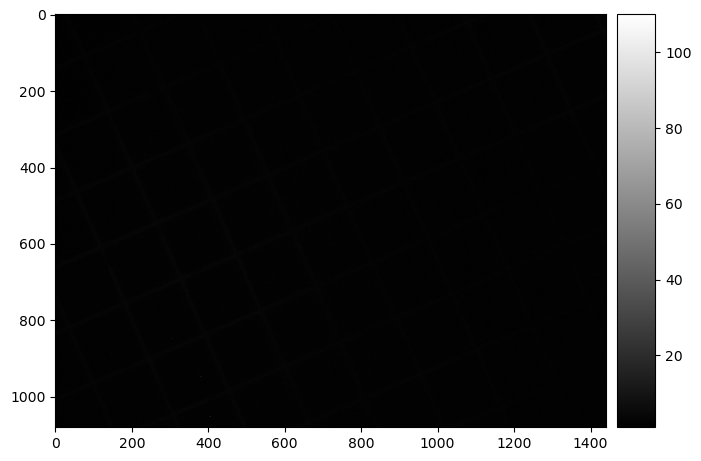

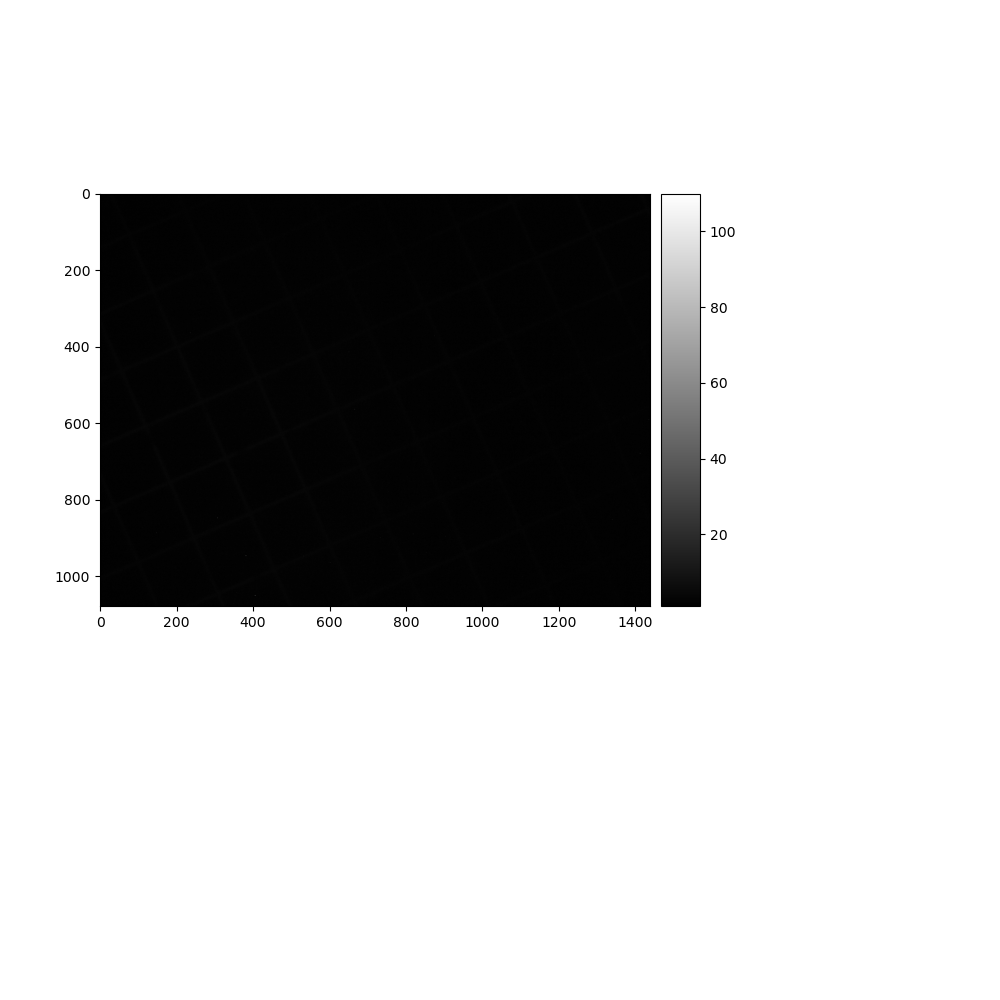

In [16]:
get_magnification()

In [43]:
x1, y1, x2, y2 =31, 814, 619, 564
magnification, pixel_size_object = calculate_magnification(x1, y1, x2, y2, grid_size=400e-6, camera_size=3.45e-6)
calculate_objectsamplingfrequency(pixel_size_object)

Pixel size of camera: 3.45e-06
Pixel size in object plane: 6.260371216900035e-07
Magnification: 5.510855315874297
Object sampling frequency in mm: 1597.3493669200861


1597349.366920086

In [19]:
%matplotlib inline

In [2]:
mag = 5.510855315874297
focal_length = 0.02095 #20.95 mm from lab 1

zi = focal_length * (1 + mag)
print("Image distance (meters)", zi)

Image distance (meters) 0.13640241886756652


In [45]:
def make_psf(r, coefs, mode_indices, nxy, dx=3.45e-6):
    lambd = 540e-9
    zi = 136.40241886756652e-3 
    
    x, y, fx, fy = setup_grids(N=nxy, dx=dx)  
    FX, FY = np.meshgrid(-lambd * zi * fx, -lambd * zi * fx)
        
    z_sum = zernike(-lambd * zi * fx / r, -lambd * zi * fy / r, mode_indices, coefs)
    phase = np.exp(-1j * 2 * np.pi * z_sum)
    
    H = (FX**2 + FY**2) < r**2
    H_with_aberration = H * phase
    
    h = fftshift(ifft2(ifftshift(H_with_aberration)))
    psf = np.abs(h)**2
    psf /= np.sum(psf)
    
    return psf

<div class="alert alert-block alert-warning">
<font color=black>

We don’t know the exact size of the exit pupil. Let’s estimate that first using **in-focus** data at wide open aperture.
</font> 
</div>

<div class="alert alert-block alert-success">
<font color=black>

2. Perform an estimation of the exit pupil size and the two Zernike tilt parameters (to ensure subpixel centering of your PSF). Paste below the measured PSF, estimated PSF, and the size of the aperture from your optimization. <br/><br/>
HINTS: This optimization is nonlinear and highly subject to local optima. 
- You will want to start with some good starting guesses in order to find the correct solution. 
- This includes a good guess of the exit pupil size and of the tilt parameters. 
- Recall that the tilts should be close to zero if your PSF is properly centered.
- The parameter `sigma0` in the `options` parameter passed to CMA-ES is a variance that controls the level of randomness in the search. If your search appears to get stuck far from an optima, you might want to increase this value.

</font> 
</div>

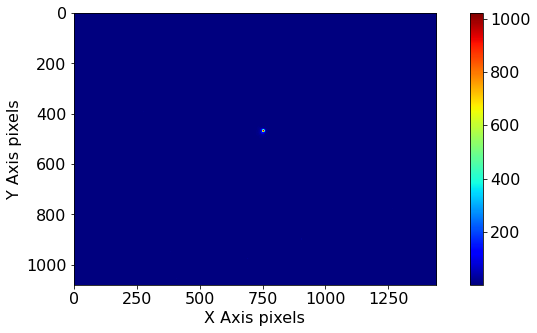

In [40]:
#get pupil image

test_image = continuous_capture_jet()

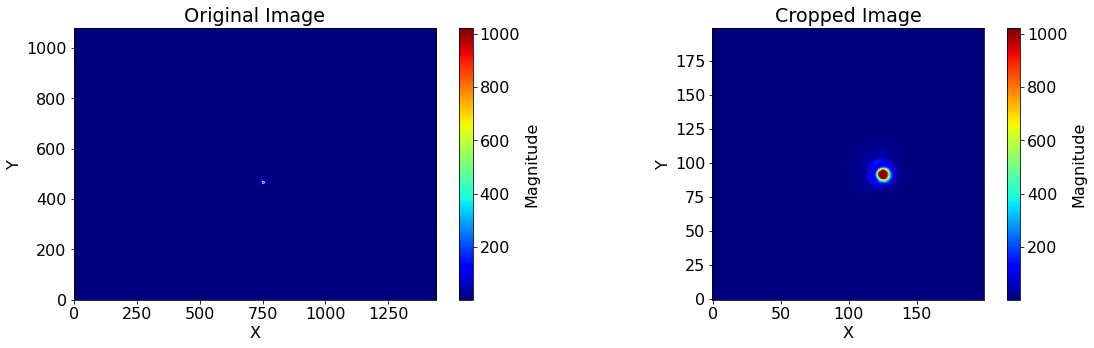

(array([[1, 1, 1, ..., 2, 2, 1],
        [1, 1, 1, ..., 2, 2, 1],
        [1, 1, 1, ..., 1, 2, 2],
        ...,
        [1, 2, 2, ..., 2, 2, 1],
        [2, 1, 2, ..., 2, 1, 2],
        [1, 2, 2, ..., 1, 1, 1]], dtype=uint16),
 array([[1, 1, 1, ..., 2, 1, 2],
        [2, 1, 1, ..., 2, 1, 1],
        [1, 1, 1, ..., 2, 2, 1],
        ...,
        [1, 1, 1, ..., 2, 2, 1],
        [1, 2, 2, ..., 2, 1, 1],
        [2, 1, 2, ..., 1, 2, 1]], dtype=uint16))

In [41]:
capture_image("test_image")

In [42]:
wide_green = average_images(100)
np.save("wide_green_lab4", wide_green)

image number taken: 10
image number taken: 20
image number taken: 30
image number taken: 40
image number taken: 50
image number taken: 60
image number taken: 70
image number taken: 80
image number taken: 90
image number taken: 100


In [43]:
green_darkfield = average_images(50)
np.save("green_darkfield_lab4", green_darkfield)

image number taken: 10
image number taken: 20
image number taken: 30
image number taken: 40
image number taken: 50


In [46]:
wide_green = np.load("Lab4_IMAGES/wide_green_lab4.npy")
green_darkfield = np.load("Lab4_IMAGES/green_darkfield_lab4.npy")

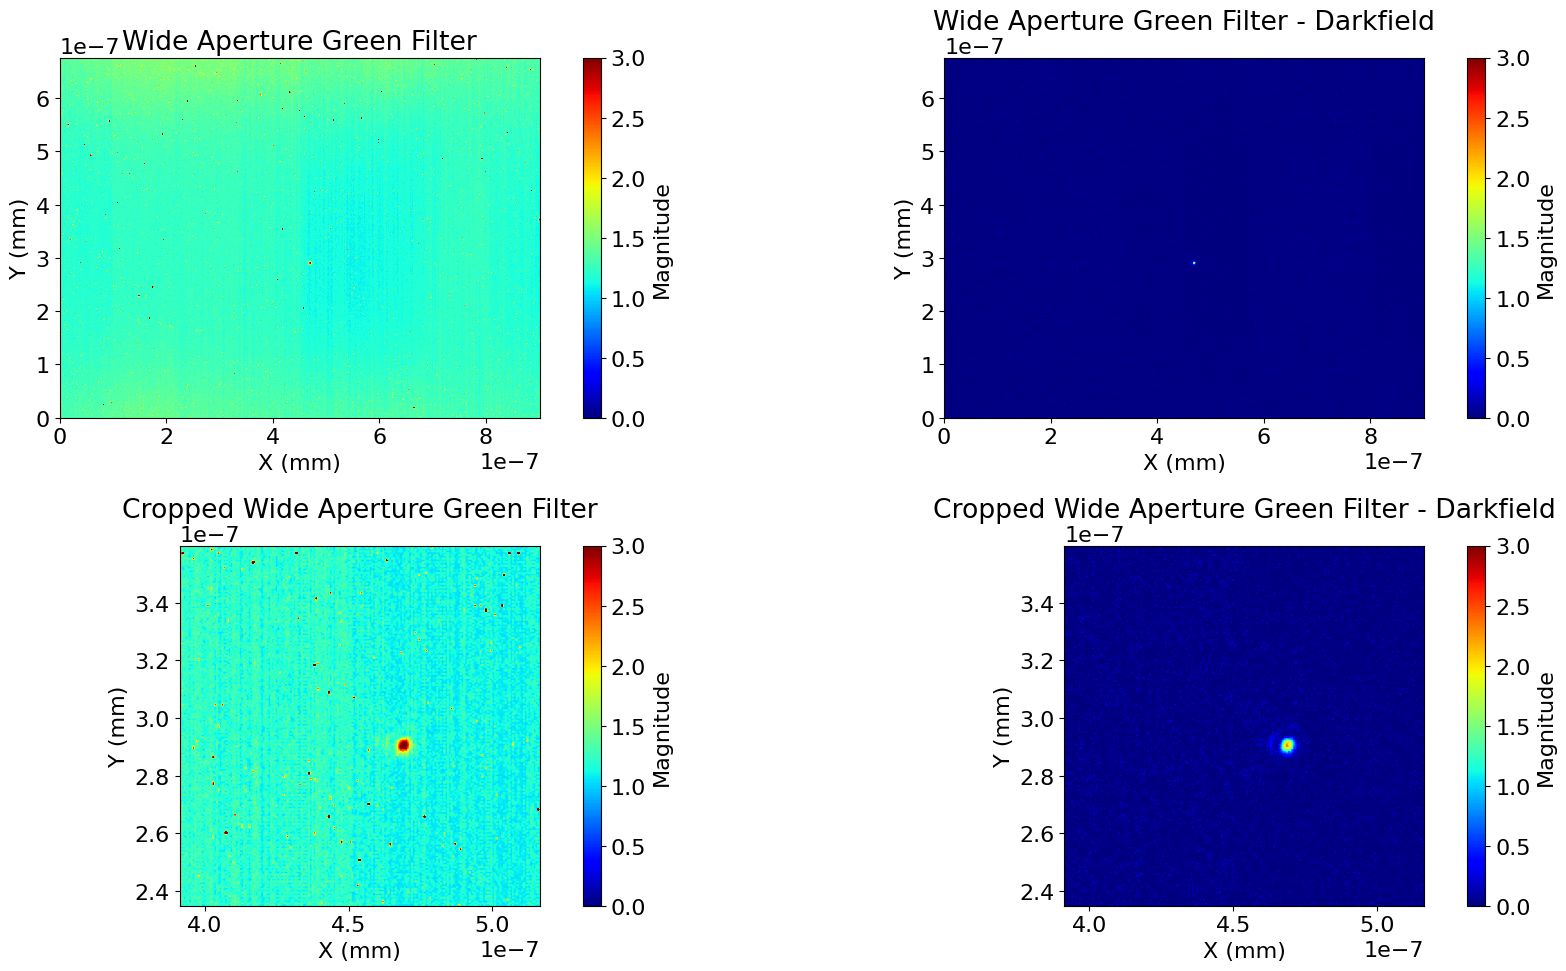

In [79]:
x1,y1,x2,y2 = 625, 375, 825, 575
vmin, vmax = 0, 3
_ = show_zoomed(wide_green, green_darkfield, x1, y1, x2, y2, image_name='Wide Aperture Green Filter', cropped_image_name='Cropped Wide Aperture Green Filter', mm_per_pixel = (6.260371216900035e-07/1000), vmin=vmin, vmax=vmax)

In [80]:
cropped_image_absolute = wide_green[y1:y2, x1:x2] - green_darkfield[y1:y2, x1:x2]
target_psf = cropped_image_absolute

In [81]:
def objfunc(xv, mpsf, mode_indices):

    r = xv[0]
    coefs = xv[1:]

    nxy = mpsf.shape[0] 
    est_psf = make_psf(r, coefs, mode_indices, nxy)
    
    mpsf_norm = mpsf / np.sum(mpsf)
    est_psf_norm = est_psf / np.sum(est_psf)
    diff = np.abs(mpsf_norm - est_psf_norm)
    
    val = np.sum((mpsf_norm - est_psf_norm) ** 2)
    
    return val

(15_w,30)-aCMA-ES (mu_w=8.6,w_1=20%) in dimension 3 (seed=911279, Sun Apr 27 23:14:04 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     30 3.003849799859700e-03 1.0e+00 9.14e-02  6e-02  1e-01 0:00.1
    2     60 1.548756462888415e-02 1.6e+00 8.48e-02  3e-02  1e-01 0:00.2
    3     90 3.161232605403443e-03 2.9e+00 7.58e-02  2e-02  9e-02 0:00.2
   10    300 2.571082656433965e-03 6.5e+01 5.50e-02  8e-04  6e-02 0:00.7
   20    600 2.376138744692876e-03 5.4e+02 1.49e-01  4e-04  9e-02 0:01.4
   30    900 2.357670770061393e-03 1.0e+03 5.10e-02  2e-05  4e-03 0:02.0
   40   1200 2.357655644598690e-03 3.3e+03 1.40e-02  2e-06  4e-04 0:02.6
   46   1380 2.357655635895236e-03 1.9e+04 1.18e-02  2e-06  4e-04 0:03.0

Optimization Results:
Initial guess: [0.0002, -0.1, 0]
Optimized coefficients: [ 0.00149448 -0.36579763  0.18216561]
Final objective function value: 0.002357655635895236
Stopping criterion: {'tolfun': 1e-08}


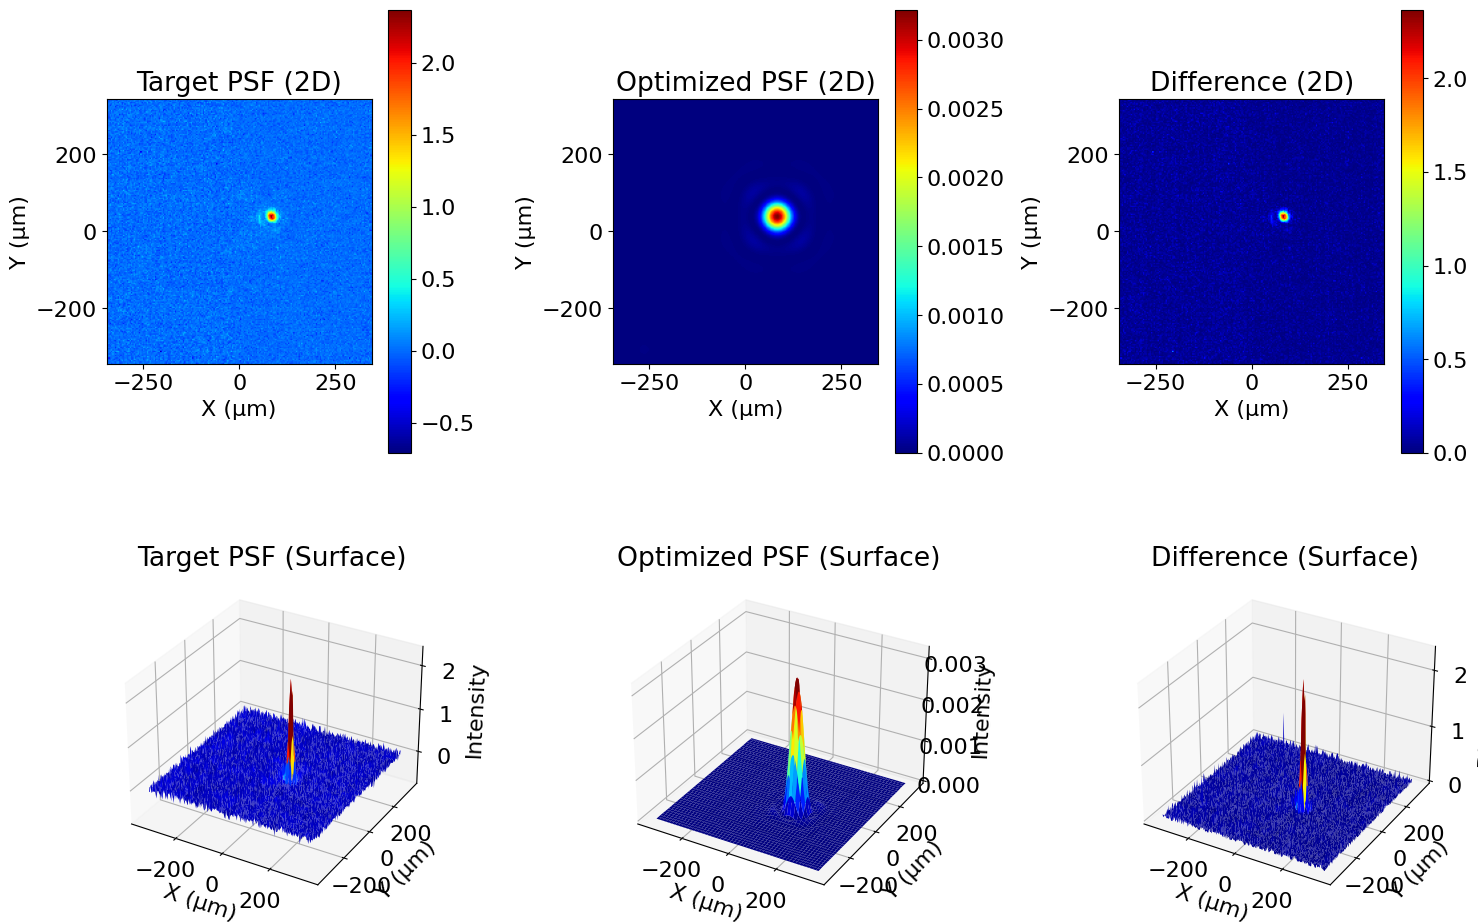

In [ ]:
nxy = 200
dx = 3.45e-6

pupil_radius_guess = 0.0002 # in 
x_tilt_guess = -0.1
y_tilt_guess = 0

mode_indices = [2, 3]
x0 = [pupil_radius_guess, x_tilt_guess, y_tilt_guess]

sigma0 = 0.1
popsize = 30
opts = {
    'tolfun': 1e-8,
    'tolx': 1e-8,
    'verb_disp': 10,
    'popsize': popsize,
}

es = cma.CMAEvolutionStrategy(x0, sigma0, opts)

fit = np.empty(popsize)
iteration=0
max_iterations=100

while not es.stop() and iteration < max_iterations:
    iteration += 1
    solutions = es.ask()
    
    for i, soln in enumerate(solutions):
        fit[i] = objfunc(soln, target_psf, mode_indices)
        
    es.tell(solutions, fit)
    es.disp(10)
    
xopt = es.result.xbest
objfuncopt = es.result.fbest

print("\nOptimization Results:")
print(f"Initial guess: {x0}")
print(f"Optimized coefficients: {xopt}")
print(f"Final objective function value: {objfuncopt}")
print(f"Stopping criterion: {es.stop()}")

# Generate the optimized PSF
r = xopt[0]
xopt = xopt[1:]

optimized_psf = make_psf(r, xopt, mode_indices, nxy)

x1, y1, x2, y2 = 625, 375, 825, 575 

mm_per_pixel = 6.260371216900035e-07/1000
N = 200
size_in_mm = N * mm_per_pixel
extent = [-size_in_mm/2, size_in_mm/2, -size_in_mm/2, size_in_mm/2]

plot_psf_comparison(target_psf, optimized_psf, extent=extent)


Optimized Exit Pupil Size: 0.00149448

Optimized X-Tilt: -0.3658

Optimized Y-Tilt: 0.1822

The x-tilt and y-tilt optimization seems accurate according to the 2D and surface plots of the target and optimized PSF. The exit pupil size seems large; however, the optimization was likely less effective for this due to the noise in the target PSF image. The pupil size is ~0.001494; however, according to the target PSF image it is likely around half the estimated size, probably closer to ~0.0007.

<div class="alert alert-block alert-success">
<font color=black>

3. Now, let’s consider a **defocused data set**. Select/collect a defocused PSF with a small to moderate level of defocus. Fix the aperture to the value you just calculated and estimate the level of defocus (and tilts, since they remain important). Show your measured PSF, estimated PSF, and state your estimated defocus.

</font> 
</div>

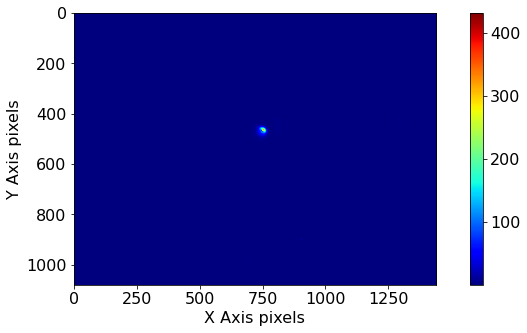

In [51]:
test_2 = continuous_capture_jet()

In [52]:
defocused_green = average_images(100)
np.save("defocused_green_lab4", defocused_green)

image number taken: 10
image number taken: 20
image number taken: 30
image number taken: 40
image number taken: 50
image number taken: 60
image number taken: 70
image number taken: 80
image number taken: 90
image number taken: 100


In [88]:
defocused_green = np.load("Lab4_IMAGES/defocused_green_lab4.npy")

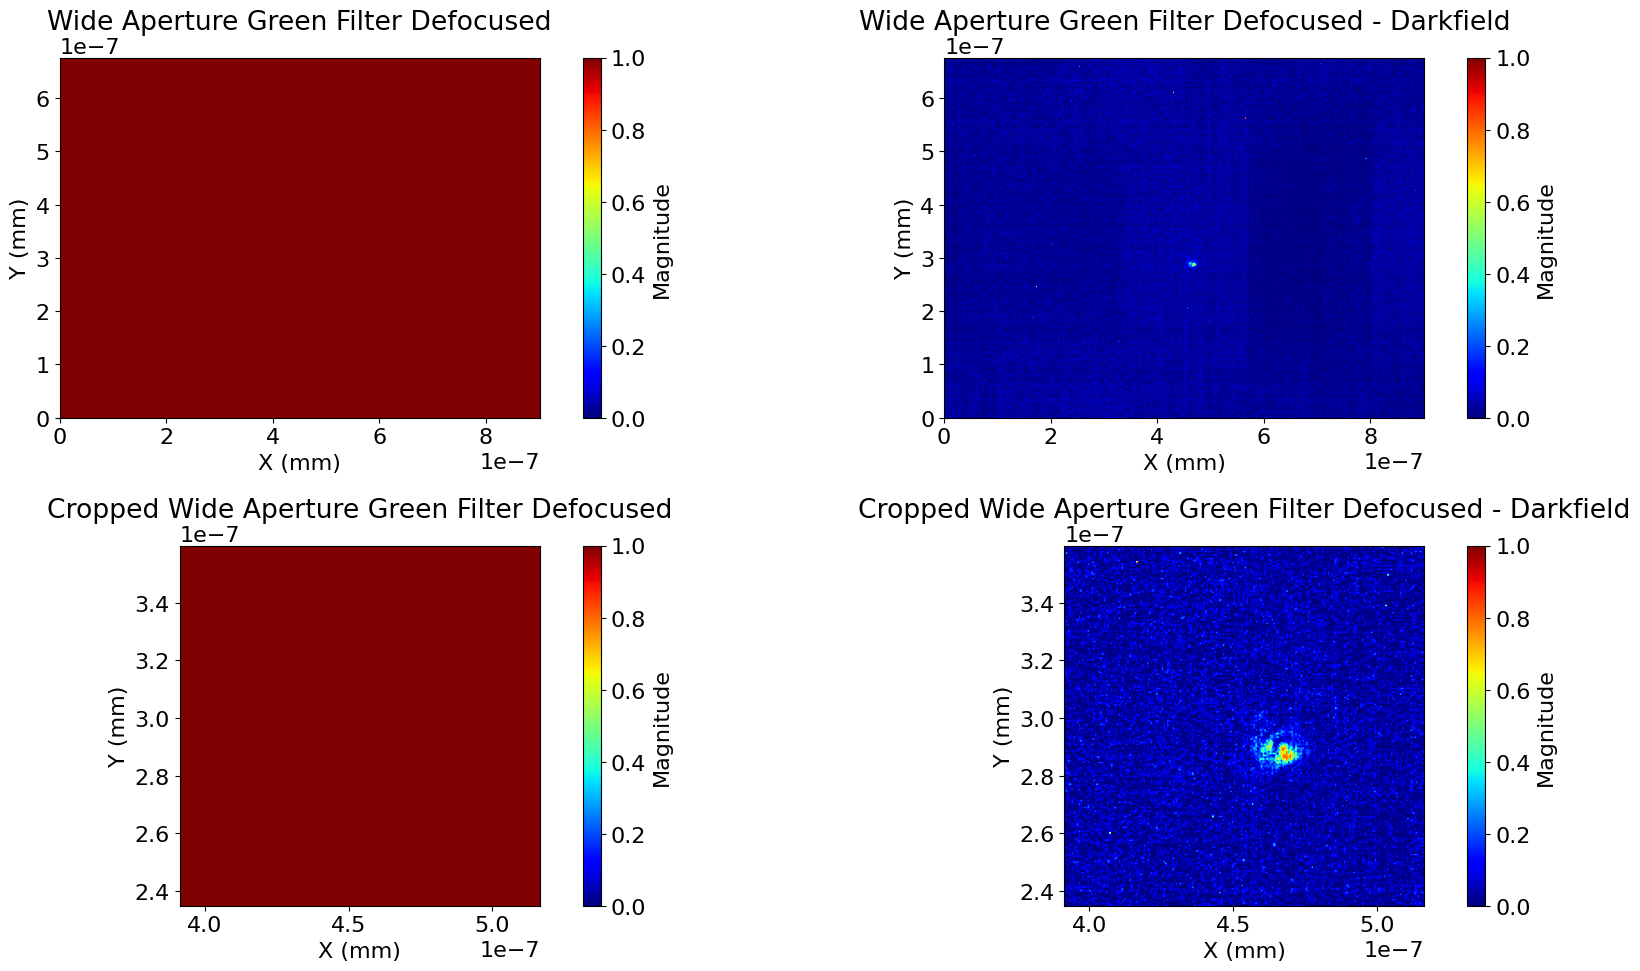

In [89]:
x1,y1,x2,y2 = 625, 375, 825, 575
vmin, vmax = 0, 1
_ = show_zoomed(defocused_green, green_darkfield, x1, y1, x2, y2, image_name='Wide Aperture Green Filter Defocused', cropped_image_name='Cropped Wide Aperture Green Filter Defocused', mm_per_pixel = (6.260371216900035e-07/1000), vmin=vmin, vmax=vmax)

In [90]:
defocused_absolute = defocused_green[y1:y2, x1:x2] - green_darkfield[y1:y2, x1:x2]
target_psf_2 = defocused_absolute

In [100]:
def objfunc(xv, mpsf, mode_indices, r):

    coefs = xv
        
    nxy = mpsf.shape[0] 
    est_psf = make_psf(r, coefs, mode_indices, nxy)
    
    mpsf_norm = mpsf / np.sum(mpsf)
    est_psf_norm = est_psf / np.sum(est_psf)
    diff = np.abs(mpsf_norm - est_psf_norm)
    
    val = np.sum((mpsf_norm - est_psf_norm) ** 2)
    
    return val

(50_w,100)-aCMA-ES (mu_w=27.0,w_1=8%) in dimension 3 (seed=923201, Sun Apr 27 23:29:16 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    100 1.114422258253423e-04 1.0e+00 9.35e-01  8e-01  1e+00 0:00.2
    2    200 1.109691818961548e-04 1.4e+00 9.28e-01  7e-01  9e-01 0:00.5
    3    300 1.109959872534613e-04 1.5e+00 8.20e-01  5e-01  8e-01 0:00.7
   10   1000 1.104218693284327e-04 4.7e+00 8.87e-01  3e-01  6e-01 0:02.3
   20   2000 1.099370567822735e-04 8.9e+00 6.79e-01  2e-03  1e-02 0:04.6
   30   3000 1.099359205645103e-04 3.9e+00 5.18e-01  5e-06  2e-05 0:06.8
   36   3600 1.099359205500737e-04 4.9e+00 4.13e-01  1e-07  4e-07 0:08.2

Optimization Results:
Initial guess: [0, 0, 0]
Optimized coefficients: [-0.43599305 -0.17620349  0.66603113]
Final objective function value: 0.00010993592055007367
Stopping criterion: {'tolfunhist': 1e-12}


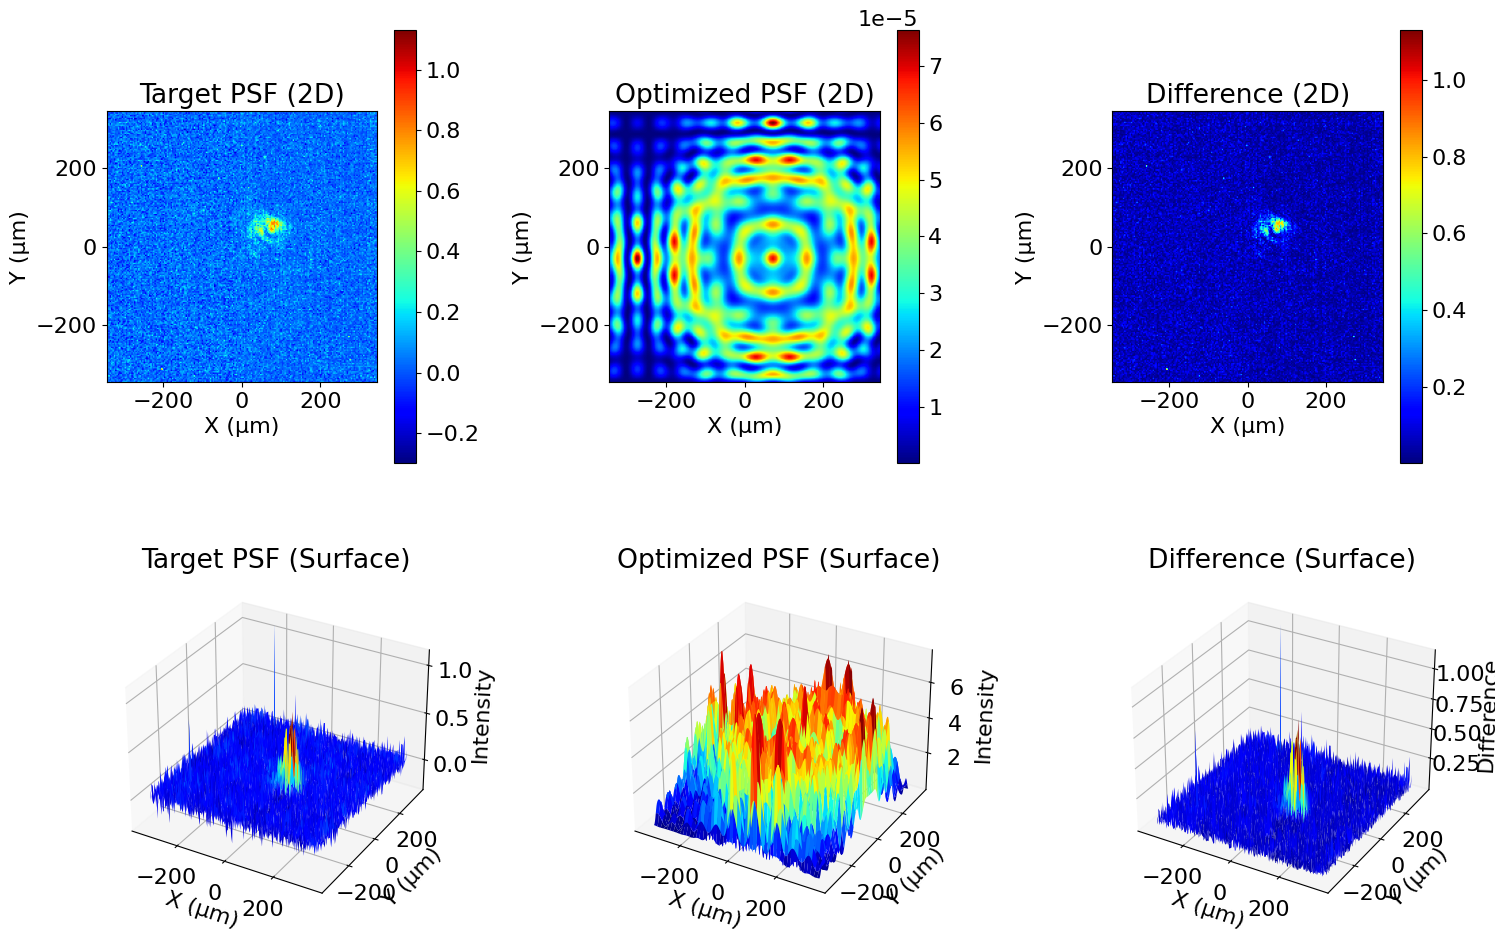

In [ ]:
nxy = 200
dx = 3.45e-6
r = 2e-3

x_tilt_guess = 0
y_tilt_guess = 0
defocus_guess = 0

mode_indices = [2, 3, 4]
x0 = [x_tilt_guess, y_tilt_guess, defocus_guess]

sigma0 = 1
popsize = 100
opts = {
    'tolfun': 1e-15,
    'tolx': 1e-15,
    'verb_disp': 10,
    'popsize': popsize,
}

es = cma.CMAEvolutionStrategy(x0, sigma0, opts)

fit = np.empty(popsize)
iteration=0
max_iterations=300

while not es.stop() and iteration < max_iterations:
    iteration += 1
    solutions = es.ask()
    
    for i, soln in enumerate(solutions):
        fit[i] = objfunc(soln, target_psf_2, mode_indices, r)
        
    es.tell(solutions, fit)
    es.disp(10)
    
xopt = es.result.xbest
objfuncopt = es.result.fbest

print("\nOptimization Results:")
print(f"Initial guess: {x0}")
print(f"Optimized coefficients: {xopt}")
print(f"Final objective function value: {objfuncopt}")
print(f"Stopping criterion: {es.stop()}")

# Generate the optimized PSF

optimized_psf_2 = make_psf(r, xopt, mode_indices, nxy)

x1, y1, x2, y2 = 625, 375, 825, 575 

um_per_pixel = 6.260371216900035e-07
N = 200
size_in_um = N * um_per_pixel
extent = [-size_in_um/2, size_in_um/2, -size_in_um/2, size_in_um/2]

plot_psf_comparison(target_psf_2, optimized_psf_2, extent=extent)

The estimated defocus was 0.666 according to the optimization. Although the optimized PSF graph does not look exactly the same as the target PSF, this is likely due to the target PSF already being at low intensity due to inadequate image capture. The optimized PSF surface has very low intensities (on the scale of 10^-5) and is likely accounting for the significant noise. 

The optimization was run many times with various popsize, max_iteration, and initial parameter guesses with defocus = ~0.67 almost always being the end result. Thus, the optimization may likely only be improved by improving image aquisition.

<div class="alert alert-block alert-success">
<font color=black>

4. Repeat the above estimation but include astigmatism, coma, and spherical aberration Zernikes. Show your measured PSF, estimated PSF, and state your estimated aberration parameters. Additionally, show the resulting pupil phase function (e.g. the weighted sum of these Zernikes that fits this data). Are these estimates different than the previous fit?
</font> 
</div>

In [105]:
defocused_absolute = defocused_green[y1:y2, x1:x2] - green_darkfield[y1:y2, x1:x2]
target_psf_3 = defocused_absolute

(10_w,20)-aCMA-ES (mu_w=5.9,w_1=27%) in dimension 8 (seed=993784, Sun Apr 27 23:21:07 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     20 1.778623703186085e-04 1.0e+00 1.10e-01  1e-01  1e-01 0:00.1
    2     40 1.460393558933547e-04 1.4e+00 1.31e-01  1e-01  2e-01 0:00.2
    3     60 1.323290531200564e-04 1.6e+00 1.38e-01  1e-01  2e-01 0:00.3
   10    200 1.198665696415245e-04 2.7e+00 2.58e-01  2e-01  4e-01 0:00.9
   20    400 1.230236867543702e-04 3.4e+00 3.16e-01  2e-01  4e-01 0:01.8
   30    600 1.191864752418590e-04 4.1e+00 1.63e-01  1e-01  2e-01 0:02.7
   40    800 1.059928172454138e-04 5.5e+00 1.26e-01  6e-02  2e-01 0:03.5
   50   1000 1.041595671513333e-04 5.8e+00 9.58e-02  4e-02  1e-01 0:04.4
   60   1200 1.039645644603698e-04 4.0e+00 5.17e-02  2e-02  4e-02 0:05.2
   70   1400 1.028241175810808e-04 4.1e+00 2.33e-02  5e-03  1e-02 0:06.0
   80   1600 1.027577752889706e-04 4.5e+00 1.01e-02  2e-03  4e-03 0:06.9
   90   1800 1.027420607897640e-0

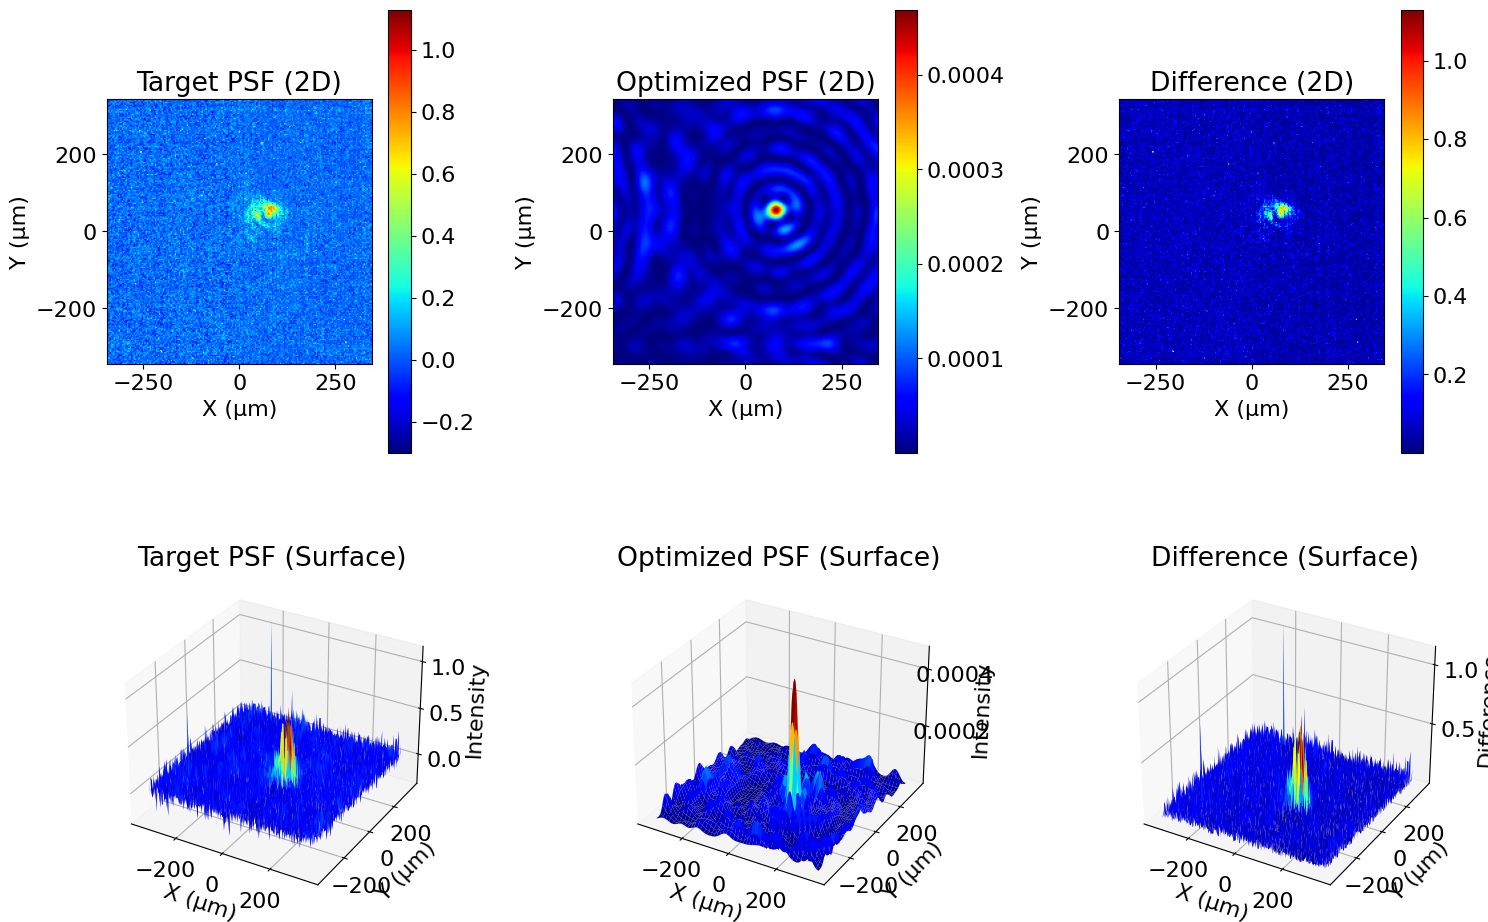

In [ ]:
nxy = 200
dx = 3.45e-6
r = 2e-3

x_tilt_guess = 0 # 2
y_tilt_guess = 0 # 3
defocus_guess = 0 # 4
x_astigmatism_guess = 0 # 5
y_astigmatism_guess = 0 # 6
y_coma_guess = 0 # 7
x_coma_guess = 0 # 8
spherical_abberation_guess = 0 # 11

mode_indices = [2,3,4,5,6,7,8,11]
x0 = [x_tilt_guess, y_tilt_guess, defocus_guess, x_astigmatism_guess, y_astigmatism_guess, y_coma_guess, x_coma_guess, spherical_abberation_guess]

sigma0 = 0.1
popsize = 20
opts = {
    'tolfun': 1e-8,
    'tolx': 1e-8,
    'verb_disp': 10,
    'popsize': popsize,
}

es = cma.CMAEvolutionStrategy(x0, sigma0, opts)

fit = np.empty(popsize)
iteration=0
max_iterations=100

while not es.stop() and iteration < max_iterations:
    iteration += 1
    solutions = es.ask()
    
    for i, soln in enumerate(solutions):
        fit[i] = objfunc(soln, target_psf_3, mode_indices, r)
        
    es.tell(solutions, fit)
    es.disp(10)
    
xopt = es.result.xbest
objfuncopt = es.result.fbest

print("\nOptimization Results:")
print(f"Initial guess: {x0}")
print(f"Optimized coefficients: {xopt}")
print(f"Final objective function value: {objfuncopt}")
print(f"Stopping criterion: {es.stop()}")

# Generate the optimized PSF

optimized_psf_3 = make_psf(r, xopt, mode_indices, nxy)

x1, y1, x2, y2 = 625, 375, 825, 575 

um_per_pixel = 6.260371216900035e-07
N = 200
size_in_um = N * um_per_pixel
extent = [-size_in_um/2, size_in_um/2, -size_in_um/2, size_in_um/2]

plot_psf_comparison(target_psf_3, optimized_psf_3, extent=extent)

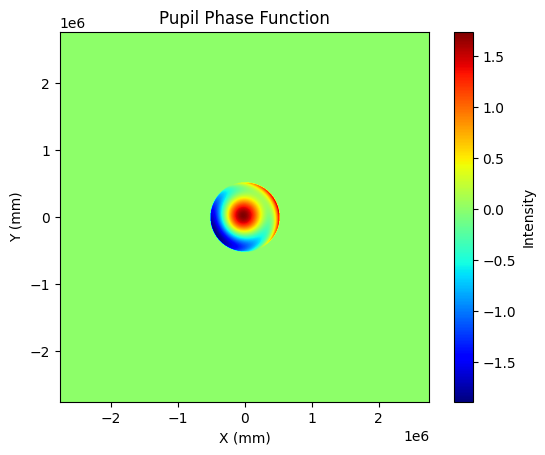

In [21]:
mode_indices = [2,3,4,5,6,7,8,11]
xopt = [-0.43971309, 0.33516731, -0.50184364, 0.03848503, 0.01161118, 0.00625187, -0.27630745, 0.37463437]

plot_pupil_phase(mode_indices, xopt, r=2e-3, lambd=540e-9, zi=0.13640241886756652, nxy=1001, dx=3.45e-6)

x_tilt → -0.43971309

y_tilt → 0.33516731

defocus → -0.50184364

x_astigmatism → 0.03848503

y_astigmatism → 0.01161118

y_coma → 0.00625187

x_coma → -0.27630745

spherical_aberration → 0.37463437

The x_tilt is almost exactly the same at ~ -0.44 while the y_tilt is changed from -0.18 to 0.34. The defocus changed as well from 0.67 to -0.50. This is likely due to the addition of other aberrations for optimization that can compensate for the different blurring and distortion patterns. 

<div class="alert alert-block alert-success">
<font color=black>

5. Repeat the above estimation once more but use all Zernike polynomials from 2-22. Show your measured PSF, estimated PSF, and state your estimated aberration parameters. Show the resulting pupil phase function. Are these estimates different than the previous ones? Lastly, show the pupil phase function for a perfectly focused system (i.e., zero out the defocus and x-,y-tilt terms and show the weighted sum of all other Zernike polynomials).
</font> 
</div>

In [112]:
defocused_absolute = defocused_green[y1:y2, x1:x2] - green_darkfield[y1:y2, x1:x2]
target_psf_4 = defocused_absolute

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 21 (seed=911694, Sun Apr 27 23:26:18 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 1.314688604805501e-04 1.0e+00 9.39e-02  9e-02  9e-02 0:00.1
    2     20 1.300833805715626e-04 1.1e+00 9.42e-02  9e-02  1e-01 0:00.3
    3     30 1.269846583941752e-04 1.1e+00 9.60e-02  9e-02  1e-01 0:00.5
   10    100 1.201537316499063e-04 1.4e+00 1.16e-01  1e-01  1e-01 0:01.4
   20    200 1.258931163350214e-04 1.6e+00 9.83e-02  9e-02  1e-01 0:02.8
   30    300 1.221603282650898e-04 1.7e+00 8.63e-02  8e-02  9e-02 0:04.2
   40    400 1.227346044916919e-04 1.7e+00 7.21e-02  7e-02  8e-02 0:05.5
   50    500 1.190415579474053e-04 1.7e+00 4.63e-02  4e-02  5e-02 0:06.9
   60    600 1.150703762781898e-04 1.7e+00 3.80e-02  3e-02  4e-02 0:08.3
   70    700 1.110661093093985e-04 1.7e+00 2.81e-02  2e-02  3e-02 0:09.6
   80    800 1.095468214438099e-04 1.8e+00 1.98e-02  2e-02  2e-02 0:11.0
   90    900 1.082270515949098e-0

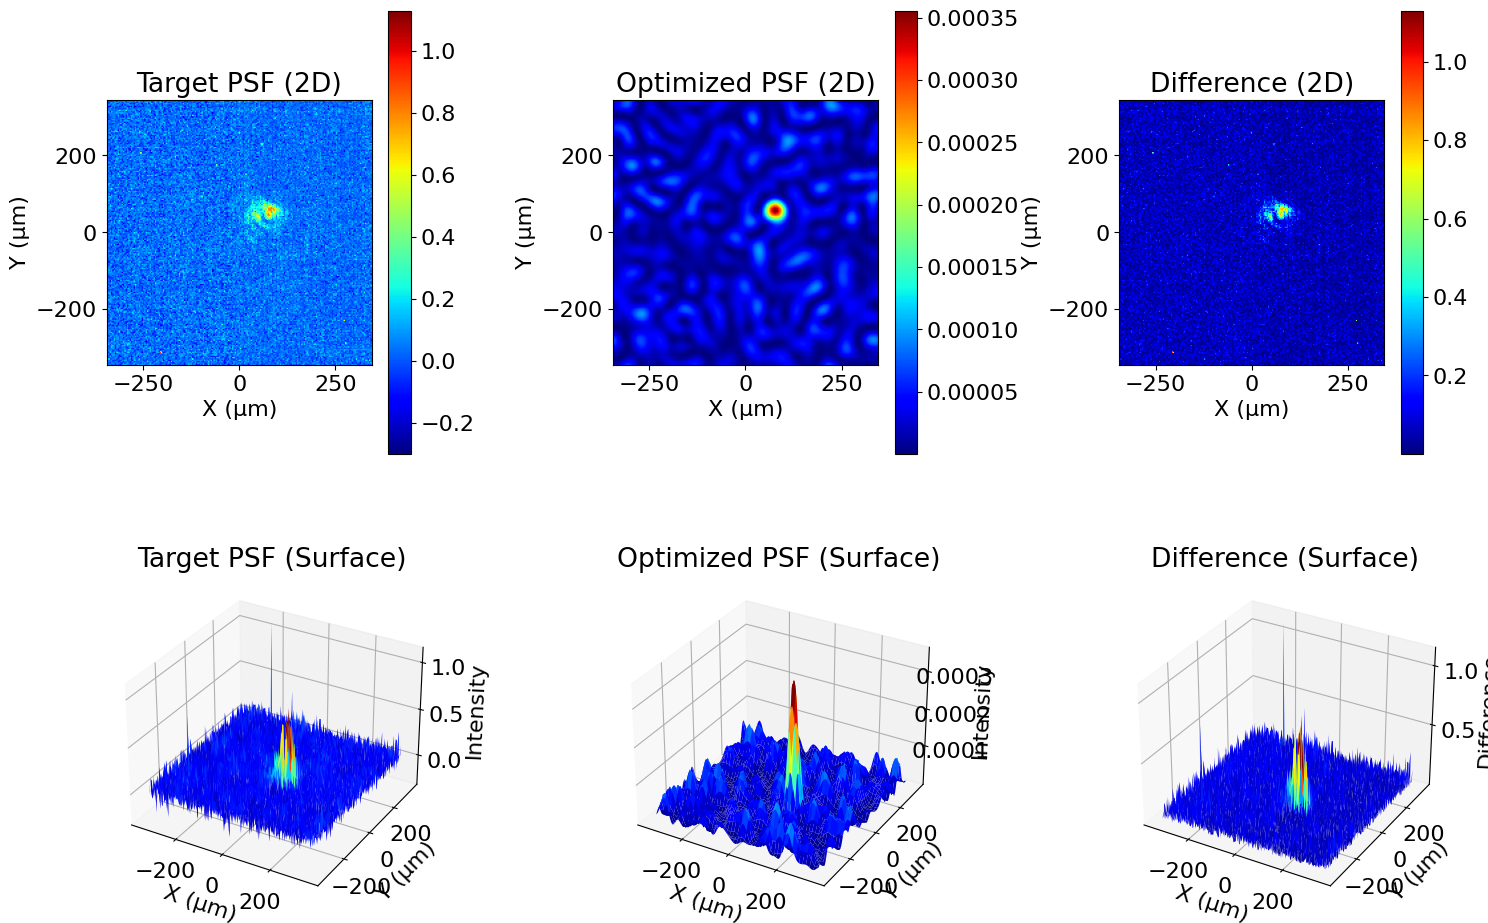

In [ ]:
nxy = 200
dx = 3.45e-6
r = 2e-3

mode_indices = np.linspace(2, 22, 21).astype(int)
x0 = np.zeros(21)

sigma0 = 0.1
popsize = 10
opts = {
    'tolfun': 1e-8,
    'tolx': 1e-8,
    'verb_disp': 10,
    'popsize': popsize,
}

es = cma.CMAEvolutionStrategy(x0, sigma0, opts)

fit = np.empty(popsize)
iteration=0
max_iterations=300

while not es.stop() and iteration < max_iterations:
    iteration += 1
    solutions = es.ask()
    
    for i, soln in enumerate(solutions):
        fit[i] = objfunc(soln, target_psf_4, mode_indices, r)
        
    es.tell(solutions, fit)
    es.disp(10)
    
xopt = es.result.xbest
objfuncopt = es.result.fbest

print("\nOptimization Results:")
print(f"Initial guess: {x0}")
print(f"Optimized coefficients: {xopt}")
print(f"Final objective function value: {objfuncopt}")
print(f"Stopping criterion: {es.stop()}")

# Generate the optimized PSF

optimized_psf_4 = make_psf(r, xopt, mode_indices, nxy)

x1, y1, x2, y2 = 625, 375, 825, 575

um_per_pixel = 6.260371216900035e-07
N = 200
size_in_um = N * um_per_pixel
extent = [-size_in_um/2, size_in_um/2, -size_in_um/2, size_in_um/2]

plot_psf_comparison(target_psf_4, optimized_psf_4, extent=extent)

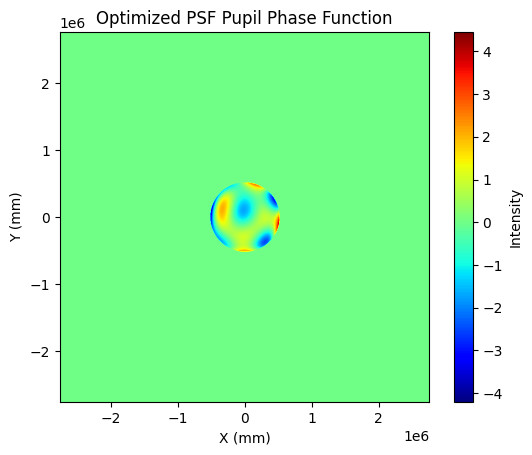

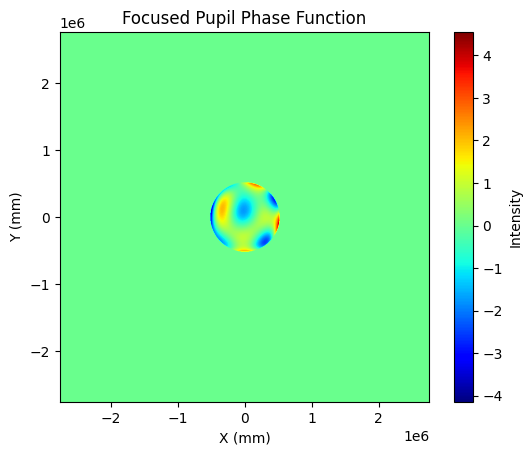

In [22]:
mode_indices = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]
xopt = [0.02194884, -0.06398861, -0.04543557,  0.03629853, -0.02918063,  0.2141011, -0.27559244,  0.03889498, -0.18359869, -0.39050472, -0.33959176, -0.03010566, 0.38917395, 0.36113061, -0.31730473, -0.23667227, -0.06454678, -0.22871117, -0.28768853, -0.31886937, 0.17400277]
xopt_focused = [0, 0, 0,  0.03629853, -0.02918063,  0.2141011, -0.27559244,  0.03889498, -0.18359869, -0.39050472, -0.33959176, -0.03010566, 0.38917395, 0.36113061, -0.31730473, -0.23667227, -0.06454678, -0.22871117, -0.28768853, -0.31886937, 0.17400277]


plot_pupil_phase(mode_indices, xopt, r=2e-3, lambd=540e-9, zi=0.13640241886756652, nxy=1001, dx=3.45e-6, title="Optimized PSF Pupil Phase Function")
plot_pupil_phase(mode_indices, xopt_focused, r=2e-3, lambd=540e-9, zi=0.13640241886756652, nxy=1001, dx=3.45e-6, title="Focused Pupil Phase Function")



2	0.02194884 (previously -0.43971309)

3	-0.06398861 (previously 0.33516731)

4	-0.04543557 (previously -0.50184364)

5	0.03629853 (previously 0.03848503)

6	-0.02918063 (previously 0.01161118)

7	0.2141011 (previously 0.00625187)

8	-0.27559244 (previously -0.27630745)

9	0.03889498

10	-0.18359869

11	-0.39050472 (previously 0.37463437)

12	-0.33959176

13	-0.03010566

14	0.38917395

15	0.36113061

16	-0.31730473

17	-0.23667227

18	-0.06454678

19	-0.22871117

20	-0.28768853

21	-0.31886937

22	0.17400277



The estimated pupil function and perfectly focused pupil function are very similar and likely only have very minute differences. They have spots of positive and negative intensity throughout the pupil.

<div class="alert alert-block alert-success">
<font color=black>

6. Collect an additional defocused data set (different than the one above). Try to reproduce the “1-wave” defocus case that you simulated previously where the center of the PSF is near-zero and the PSF has the form of an annulus (i.e., donut-shape). Conduct the estimation using Zernikes 2-22. Show the estimated pupil phase function. Also, show the pupil phase function for a perfectly focused system. How does this compare with the previous “perfect focus” estimate.
</font> 
</div>

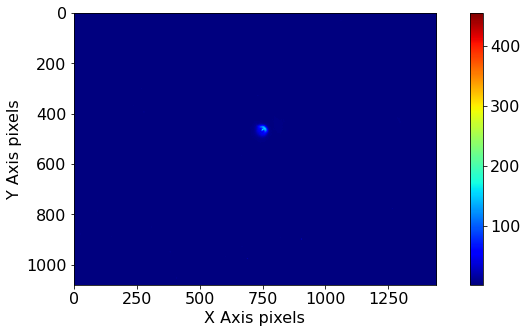

In [75]:
test_3 = continuous_capture_jet()

In [76]:
defocused_green_2 = average_images(100)
np.save("defocused_green_2_lab4", defocused_green_2)

image number taken: 10
image number taken: 20
image number taken: 30
image number taken: 40
image number taken: 50
image number taken: 60
image number taken: 70
image number taken: 80
image number taken: 90
image number taken: 100


In [124]:
defocused_green_2 = np.load("Lab4_IMAGES/defocused_green_2_lab4.npy")

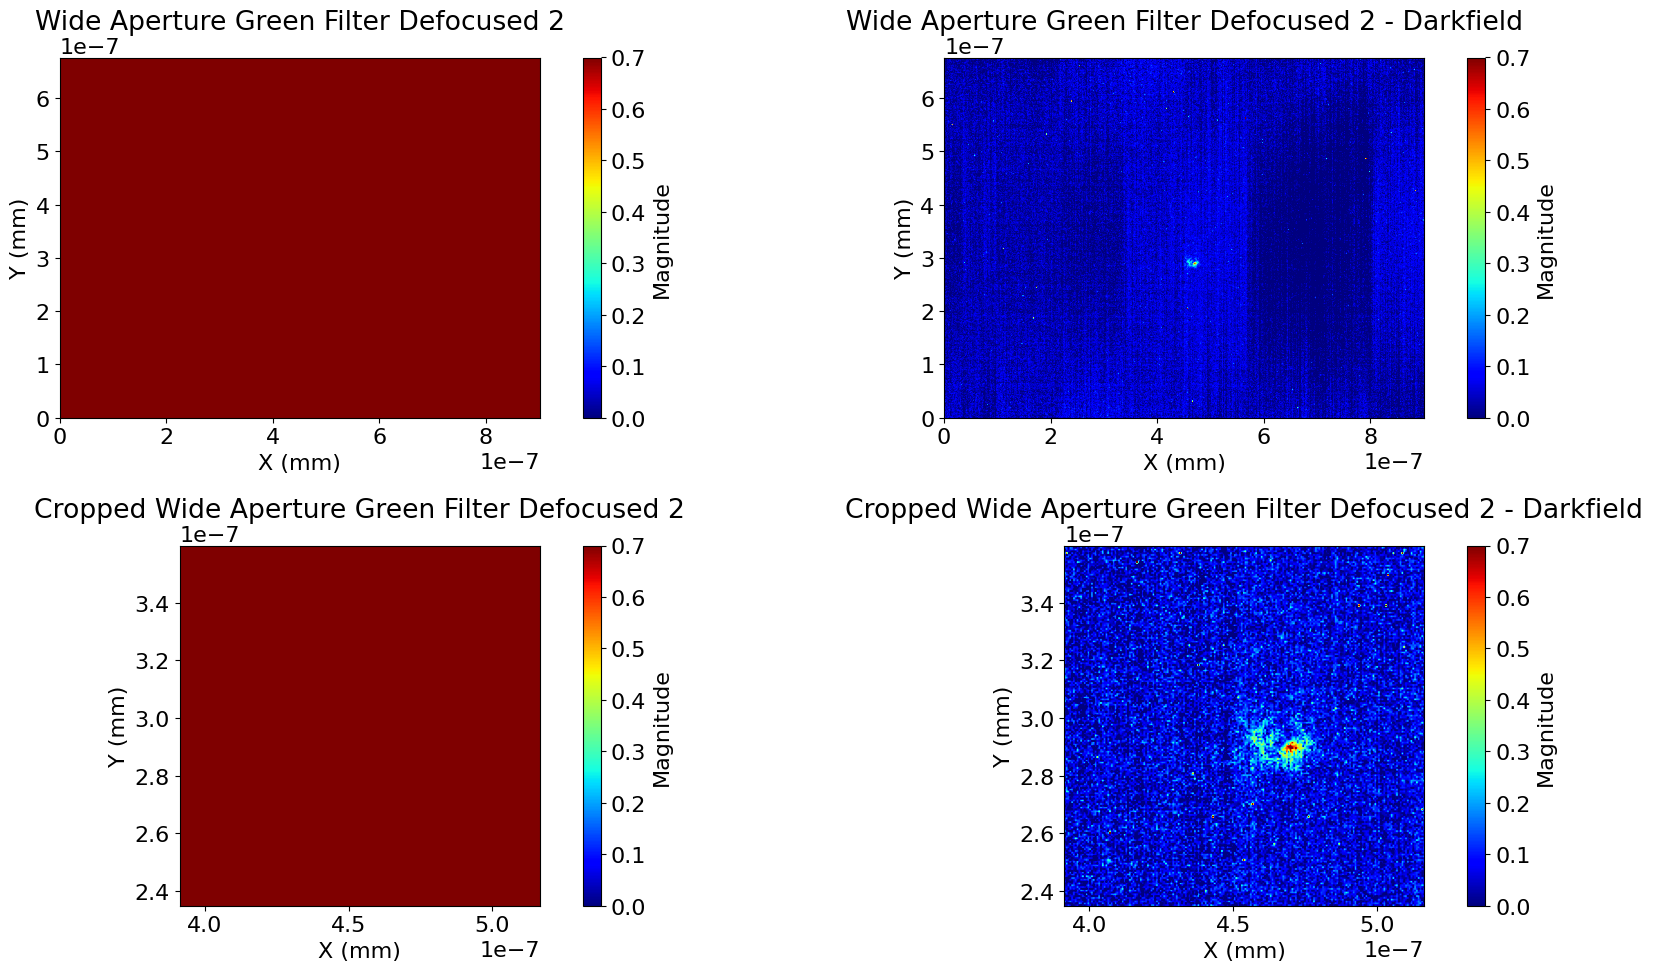

In [126]:
x1,y1,x2,y2 = 625, 375, 825, 575
vmin, vmax = 0, 0.7
_ = show_zoomed(defocused_green_2, green_darkfield, x1, y1, x2, y2, image_name='Wide Aperture Green Filter Defocused 2', cropped_image_name='Cropped Wide Aperture Green Filter Defocused 2', mm_per_pixel = (6.260371216900035e-07/1000), vmin=vmin, vmax=vmax)

In [127]:
defocused_absolute_2 = defocused_green_2[y1:y2, x1:x2] - green_darkfield[y1:y2, x1:x2]
target_psf_5 = defocused_absolute_2

(2_w,5mirr1)-aCMA-ES (mu_w=1.6,w_1=73%) in dimension 21 (seed=955294, Sun Apr 27 23:33:33 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      5 7.477649944891170e-05 1.0e+00 1.79e-01  2e-01  2e-01 0:00.1
    2     10 7.322237441350530e-05 1.1e+00 1.68e-01  2e-01  2e-01 0:00.2
    3     15 7.409933996176600e-05 1.1e+00 1.67e-01  2e-01  2e-01 0:00.2
   10     50 7.276241484289038e-05 1.3e+00 1.65e-01  2e-01  2e-01 0:00.8
   20    100 7.255753680805903e-05 1.3e+00 1.32e-01  1e-01  1e-01 0:01.5
   30    150 7.117960717460954e-05 1.3e+00 1.20e-01  1e-01  1e-01 0:02.2
   40    200 6.859867245053492e-05 1.5e+00 1.25e-01  1e-01  1e-01 0:02.9
   50    250 7.536364672359795e-05 1.7e+00 1.62e-01  2e-01  2e-01 0:03.6
   60    300 7.325476664734973e-05 1.7e+00 2.09e-01  2e-01  2e-01 0:04.3
   70    350 7.217162122500809e-05 1.7e+00 2.34e-01  2e-01  3e-01 0:04.9
   80    400 7.337479766617745e-05 1.9e+00 2.56e-01  2e-01  3e-01 0:05.6
   90    450 7.25051827536514

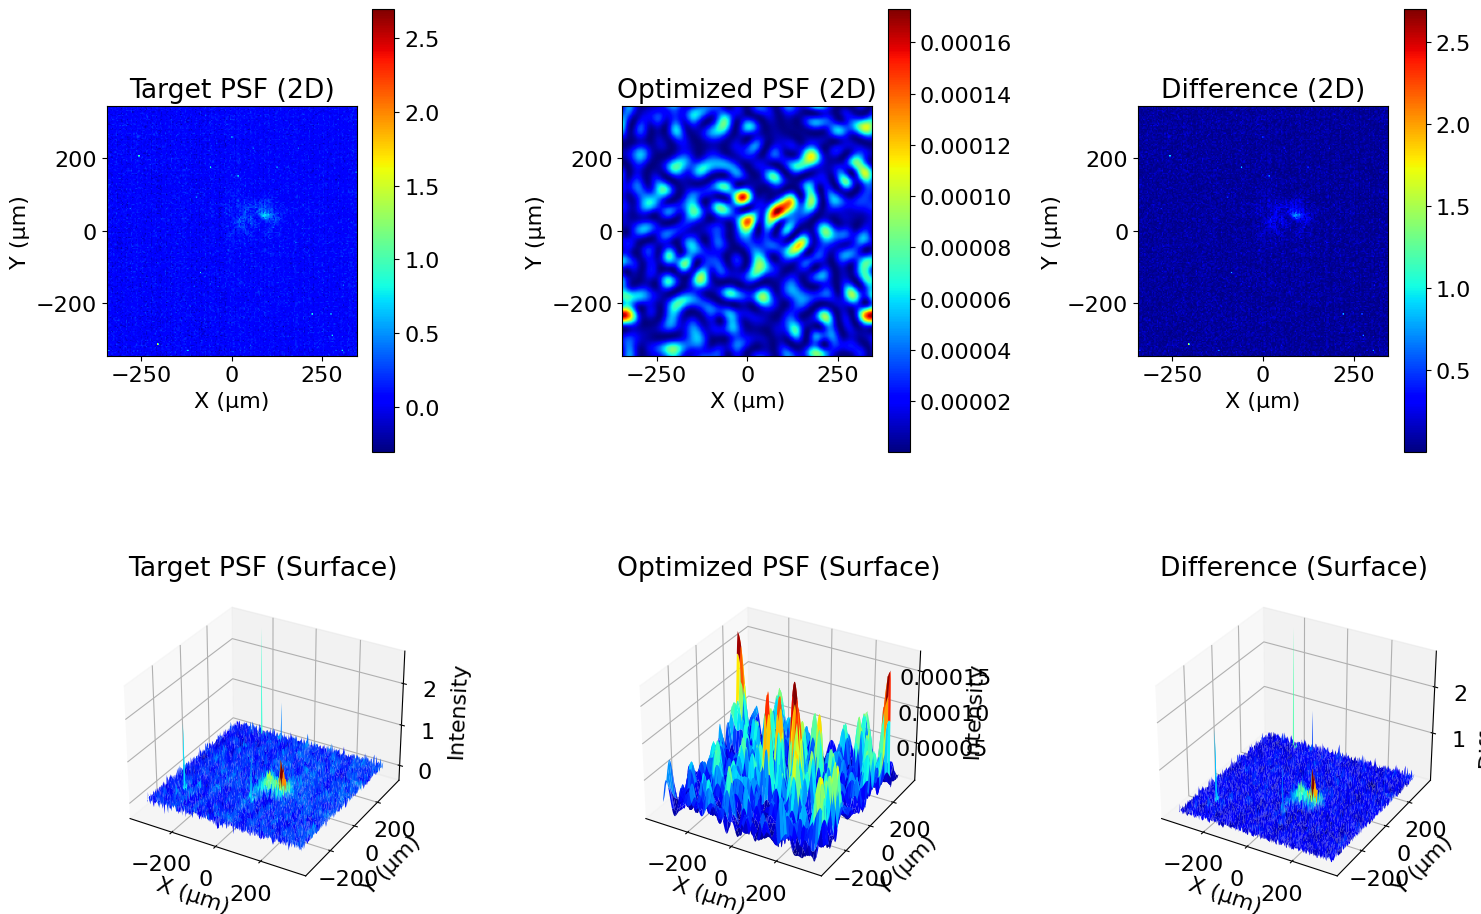

In [ ]:
nxy = 200
dx = 3.45e-6
r = 2e-3

mode_indices = np.linspace(2, 22, 21).astype(int)
x0 = np.zeros(21)

sigma0 = 0.2
popsize = 5
opts = {
    'tolfun': 1e-8,
    'tolx': 1e-8,
    'verb_disp': 10,
    'popsize': popsize,
}

es = cma.CMAEvolutionStrategy(x0, sigma0, opts)

fit = np.empty(popsize)
iteration=0
max_iterations=300

while not es.stop() and iteration < max_iterations:
    iteration += 1
    solutions = es.ask()
    
    for i, soln in enumerate(solutions):
        fit[i] = objfunc(soln, target_psf_5, mode_indices, r)
        
    es.tell(solutions, fit)
    es.disp(10)
    
xopt = es.result.xbest
objfuncopt = es.result.fbest

print("\nOptimization Results:")
print(f"Initial guess: {x0}")
print(f"Optimized coefficients: {xopt}")
print(f"Final objective function value: {objfuncopt}")
print(f"Stopping criterion: {es.stop()}")

# Generate the optimized PSF

optimized_psf_5 = make_psf(r, xopt, mode_indices, nxy)

x1, y1, x2, y2 = 625, 375, 825, 575 

um_per_pixel = 6.260371216900035e-07
N = 200
size_in_um = N * um_per_pixel
extent = [-size_in_um/2, size_in_um/2, -size_in_um/2, size_in_um/2]

plot_psf_comparison(target_psf_5, optimized_psf_5, extent=extent)

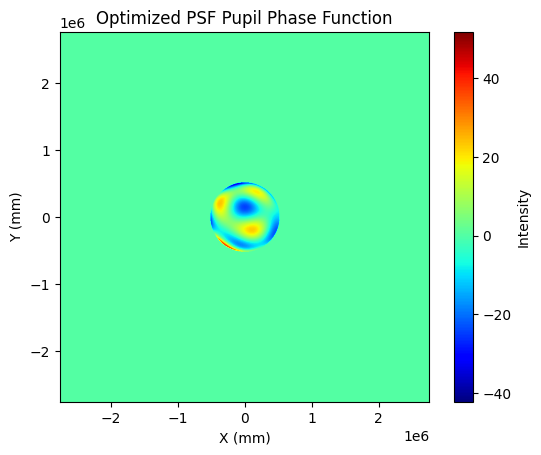

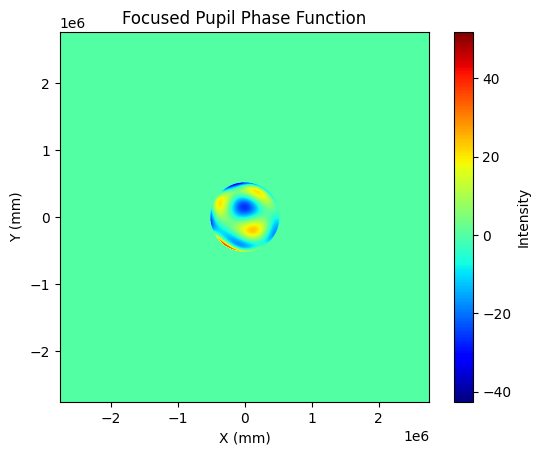

In [23]:
mode_indices = np.linspace(2, 22, 21).astype(int)
xopt = [2.24874841, 0.53704001, -0.97357353, -0.48274818, -0.17244251, 2.31927894, 1.64326011, 2.76861686, 0.67488932, -2.81316528, -1.31627721, -3.15342857, -2.31965579, 2.26192067, -0.07075671, -8.80228734, -3.22875583, 0.67282624, -1.94439906, 1.65453059, 0.84494875]
xopt_focused = [0, 0, 0, -0.48274818, -0.17244251, 2.31927894, 1.64326011, 2.76861686, 0.67488932, -2.81316528, -1.31627721, -3.15342857, -2.31965579, 2.26192067, -0.07075671, -8.80228734, -3.22875583, 0.67282624, -1.94439906, 1.65453059, 0.84494875]


plot_pupil_phase(mode_indices, xopt, r=2e-3, lambd=540e-9, zi=0.13640241886756652, nxy=1001, dx=3.45e-6, title="Optimized PSF Pupil Phase Function")
plot_pupil_phase(mode_indices, xopt_focused, r=2e-3, lambd=540e-9, zi=0.13640241886756652, nxy=1001, dx=3.45e-6, title="Focused Pupil Phase Function")



The new pupil phase function shows a very similar pattern to the previous pupil phase function where there are spots of positive and negative intensity. The center of the function is negative and it surrounded by positive intensity. Although a perfect donut-shaped PSF was not formed, the 2D graph does show the center of the PSF being near-zero.

Additionally, there are significant differences seen between the first defocused and second defocused images in the optimization parameters with a notable change in defocus from -0.04543557 to -0.97357353.

<div class="alert alert-block alert-success">
<font color=black>

**BONUS #1** Repeat a defocus experiment using another wavelength filter. Show pupil phase functions and “perfect focus” estimates. How do these compare to previous estimates?
    
**BONUS #2** Estimating the Pupil Function in an Obstructed Imaging System

Many optical imaging systems do not have simple disc-shaped pupil functions. This is true in astronomical imaging devices including telescopes with central obstructions (typically to suspend a secondary mirror in the optical path, which allows a longer “b” distance in the lens equation (or “zi” more recently) while maintaining a compact optical instrument, effectively “folding” the optical path).
We will set up a microscope where a central obstruction has been placed in the pupil. Alter your make_psf code to allow for three addition parameters for the amplitude portion of your pupil function. Specifically, allow a disc-shaped central obstruction of unknown position (x,y) and unknown diameter. For the datasets that you acquire show measured and estimated PSFs, amplitude and phase of your pupil function, and estimated aberration parameters. (You may select Zernikes based on your previous characterizations of the microscope.)

</font> 
</div>

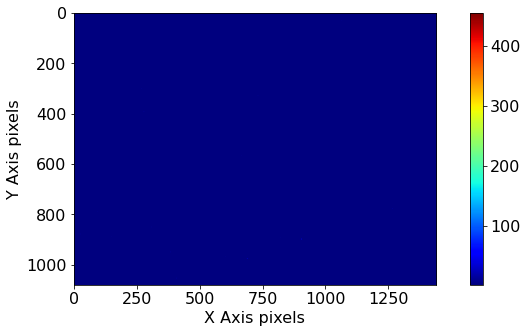

In [88]:
test_4 = continuous_capture_jet()

In [81]:
blue_darkfield = average_images(50)
np.save("blue_darkfield_lab4", blue_darkfield)

image number taken: 10
image number taken: 20
image number taken: 30
image number taken: 40
image number taken: 50


In [86]:
wide_blue = average_images(100)
np.save("wide_blue_lab4", wide_blue)

image number taken: 10
image number taken: 20
image number taken: 30
image number taken: 40
image number taken: 50
image number taken: 60
image number taken: 70
image number taken: 80
image number taken: 90
image number taken: 100


In [89]:
defocused_blue = average_images(100)
np.save("defocused_blue_lab4", defocused_blue)

image number taken: 10
image number taken: 20
image number taken: 30
image number taken: 40
image number taken: 50
image number taken: 60
image number taken: 70
image number taken: 80
image number taken: 90
image number taken: 100


In [26]:
blue_darkfield = np.load("Lab4_IMAGES/blue_darkfield_lab4.npy")
wide_blue = np.load("Lab4_IMAGES/wide_blue_lab4.npy")
defocused_blue = np.load("Lab4_IMAGES/defocused_blue_lab4.npy")

In [27]:
def make_psf(r, coefs, mode_indices, nxy, dx=3.45e-6):
    lambd = 450e-9
    zi = 136.40241886756652e-3 
    
    x, y, fx, fy = setup_grids(N=nxy, dx=dx)  
    FX, FY = np.meshgrid(-lambd * zi * fx, -lambd * zi * fx)
        
    z_sum = zernike(-lambd * zi * fx / r, -lambd * zi * fy / r, mode_indices, coefs)
    phase = np.exp(-1j * 2 * np.pi * z_sum)
    
    H = (FX**2 + FY**2) < r**2
    H_with_aberration = H * phase
    
    h = fftshift(ifft2(ifftshift(H_with_aberration)))
    psf = np.abs(h)**2
    psf /= np.sum(psf)
    
    return psf

def objfunc(xv, mpsf, mode_indices, r):

    coefs = xv
        
    nxy = mpsf.shape[0] 
    est_psf = make_psf(r, coefs, mode_indices, nxy)
    
    mpsf_norm = mpsf / np.sum(mpsf)
    est_psf_norm = est_psf / np.sum(est_psf)
    diff = np.abs(mpsf_norm - est_psf_norm)
    
    val = np.sum((mpsf_norm - est_psf_norm) ** 2)
    
    return val

In [28]:
x1,y1,x2,y2 = 625, 375, 825, 575
target_psf_6 = wide_blue[y1:y2, x1:x2] - blue_darkfield[y1:y2, x1:x2]

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 21 (seed=905198, Mon Apr 28 02:22:07 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 1.255528120626381e-03 1.0e+00 9.48e-02  9e-02  1e-01 0:00.1
    2     20 1.157324718664211e-03 1.1e+00 9.38e-02  9e-02  1e-01 0:00.3
    3     30 1.064639788822423e-03 1.1e+00 9.55e-02  9e-02  1e-01 0:00.4
   10    100 9.373087709348564e-04 1.3e+00 1.69e-01  2e-01  2e-01 0:01.4
   20    200 9.326631404427921e-04 1.6e+00 2.47e-01  2e-01  3e-01 0:03.0
   30    300 9.324840700952297e-04 1.7e+00 2.51e-01  2e-01  3e-01 0:04.4
   40    400 9.348134631340555e-04 1.8e+00 2.50e-01  2e-01  3e-01 0:05.8
   50    500 9.316204701641531e-04 1.9e+00 2.70e-01  2e-01  3e-01 0:07.2
   60    600 9.326183024528701e-04 1.9e+00 2.31e-01  2e-01  3e-01 0:08.6
   70    700 9.303928483065120e-04 2.0e+00 1.90e-01  2e-01  2e-01 0:10.0
   80    800 9.332326546074834e-04 2.1e+00 1.78e-01  2e-01  2e-01 0:11.4
   90    900 9.305402451407389e-0

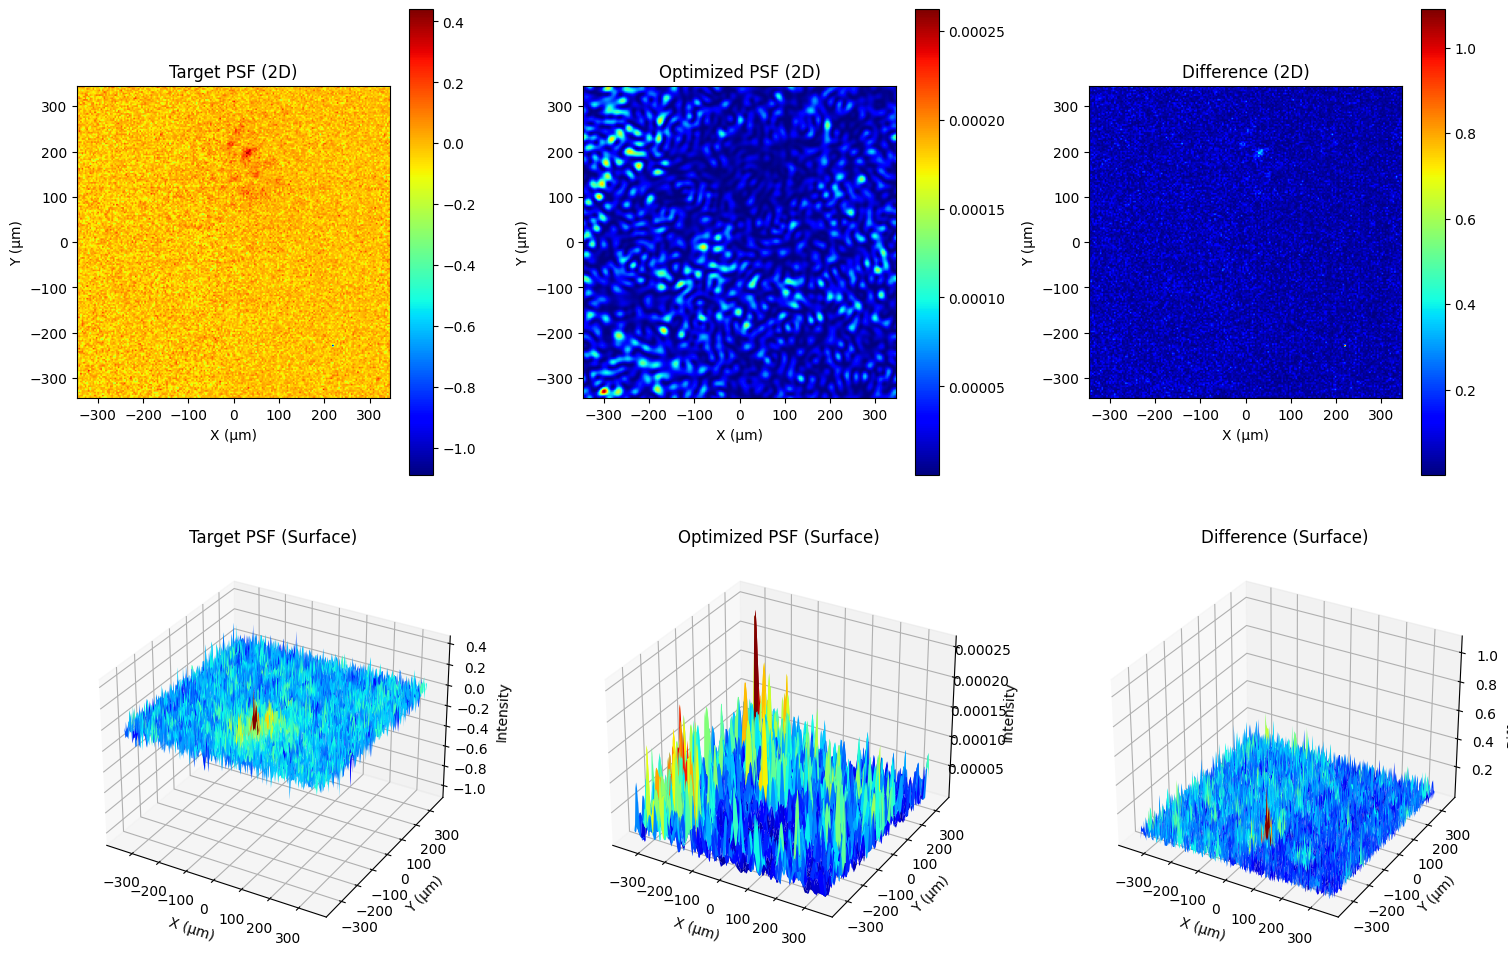

In [39]:
nxy = 200
dx = 3.45e-6
r = 2e-3

mode_indices = np.linspace(2, 22, 21).astype(int)
x0 = np.zeros(21)

sigma0 = 0.1
popsize = 10
opts = {
    'tolfun': 1e-8,
    'tolx': 1e-8,
    'verb_disp': 10,
    'popsize': popsize,
}

es = cma.CMAEvolutionStrategy(x0, sigma0, opts)

fit = np.empty(popsize)
iteration=0
max_iterations=500

while not es.stop() and iteration < max_iterations:
    iteration += 1
    solutions = es.ask()
    
    for i, soln in enumerate(solutions):
        fit[i] = objfunc(soln, target_psf_6, mode_indices, r)
        
    es.tell(solutions, fit)
    es.disp(10)
    
xopt = es.result.xbest
objfuncopt = es.result.fbest

print("\nOptimization Results:")
print(f"Initial guess: {x0}")
print(f"Optimized coefficients: {xopt}")
print(f"Final objective function value: {objfuncopt}")
print(f"Stopping criterion: {es.stop()}")

# Generate the optimized PSF

optimized_psf_6 = make_psf(r, xopt, mode_indices, nxy)

x1, y1, x2, y2 = 625, 375, 825, 575 

um_per_pixel = 6.260371216900035e-07
N = 200
size_in_um = N * um_per_pixel
extent = [-size_in_um/2, size_in_um/2, -size_in_um/2, size_in_um/2]

plot_psf_comparison(target_psf_6, optimized_psf_6, extent=extent)

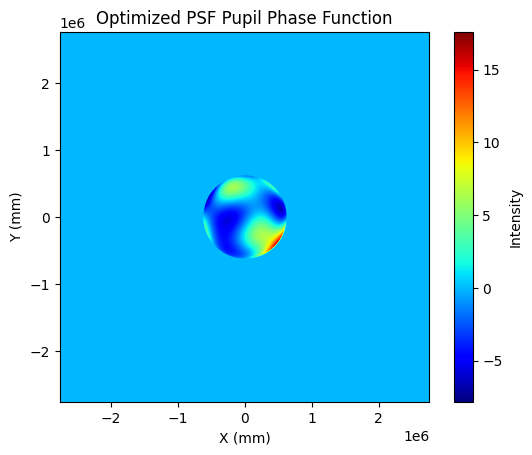

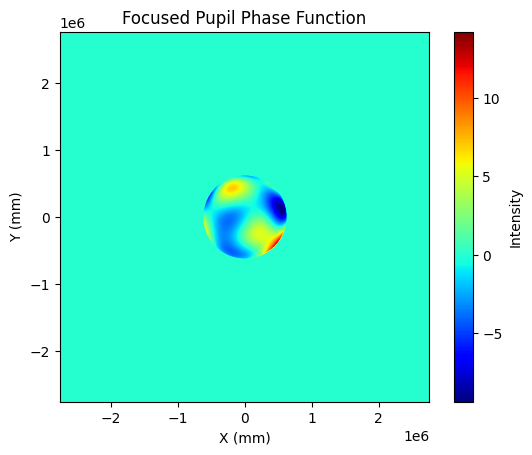

In [40]:
mode_indices = np.linspace(2, 22, 21).astype(int)
xopt = [-1.37579912, -0.19156589, 0.5770797, 2.08386286, -0.90100591, -0.24745102, 0.51697993, -1.54548889, 0.86714267, -0.12850207, 0.82213324, -0.94483056, -0.72800276, -0.200198, -0.82201949, -0.67120476, 0.25871855, 0.04947703, 0.57122132, -0.4862117, 0.31620537]
xopt_focused = [0, 0, 0, 2.08386286, -0.90100591, -0.24745102, 0.51697993, -1.54548889, 0.86714267, -0.12850207, 0.82213324, -0.94483056, -0.72800276, -0.200198, -0.82201949, -0.67120476, 0.25871855, 0.04947703, 0.57122132, -0.4862117, 0.31620537]

plot_pupil_phase(mode_indices, xopt, r=2e-3, lambd=450e-9, zi=0.13640241886756652, nxy=1001, dx=3.45e-6, title="Optimized PSF Pupil Phase Function")
plot_pupil_phase(mode_indices, xopt_focused, r=2e-3, lambd=450e-9, zi=0.13640241886756652, nxy=1001, dx=3.45e-6, title="Focused Pupil Phase Function")

In [32]:
x1,y1,x2,y2 = 625, 375, 825, 575
target_psf_7 = defocused_blue[y1:y2, x1:x2] - blue_darkfield[y1:y2, x1:x2]


(10_w,20)-aCMA-ES (mu_w=5.9,w_1=27%) in dimension 21 (seed=928836, Mon Apr 28 02:24:52 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     20 5.215167907380340e-03 1.0e+00 9.58e-02  9e-02  1e-01 0:00.3
    2     40 5.138158650975037e-03 1.1e+00 9.32e-02  9e-02  1e-01 0:00.5
    3     60 5.107259291306509e-03 1.2e+00 9.68e-02  9e-02  1e-01 0:00.8
   10    200 4.797020683661450e-03 1.4e+00 2.70e-01  3e-01  3e-01 0:02.9
   20    400 4.786773332447151e-03 1.7e+00 2.73e-01  3e-01  3e-01 0:05.6
   30    600 4.782620005051756e-03 1.9e+00 3.41e-01  3e-01  4e-01 0:08.2
   40    800 4.783688936077488e-03 2.0e+00 2.94e-01  3e-01  3e-01 0:10.9
   50   1000 4.781860553286464e-03 2.1e+00 2.68e-01  2e-01  3e-01 0:13.6
   60   1200 4.779543062537929e-03 2.3e+00 2.17e-01  2e-01  2e-01 0:16.3
   70   1400 4.780837572171056e-03 2.4e+00 1.48e-01  1e-01  2e-01 0:19.0
   80   1600 4.771906377148717e-03 2.4e+00 1.20e-01  9e-02  1e-01 0:21.8
   90   1800 4.772624574776410e-

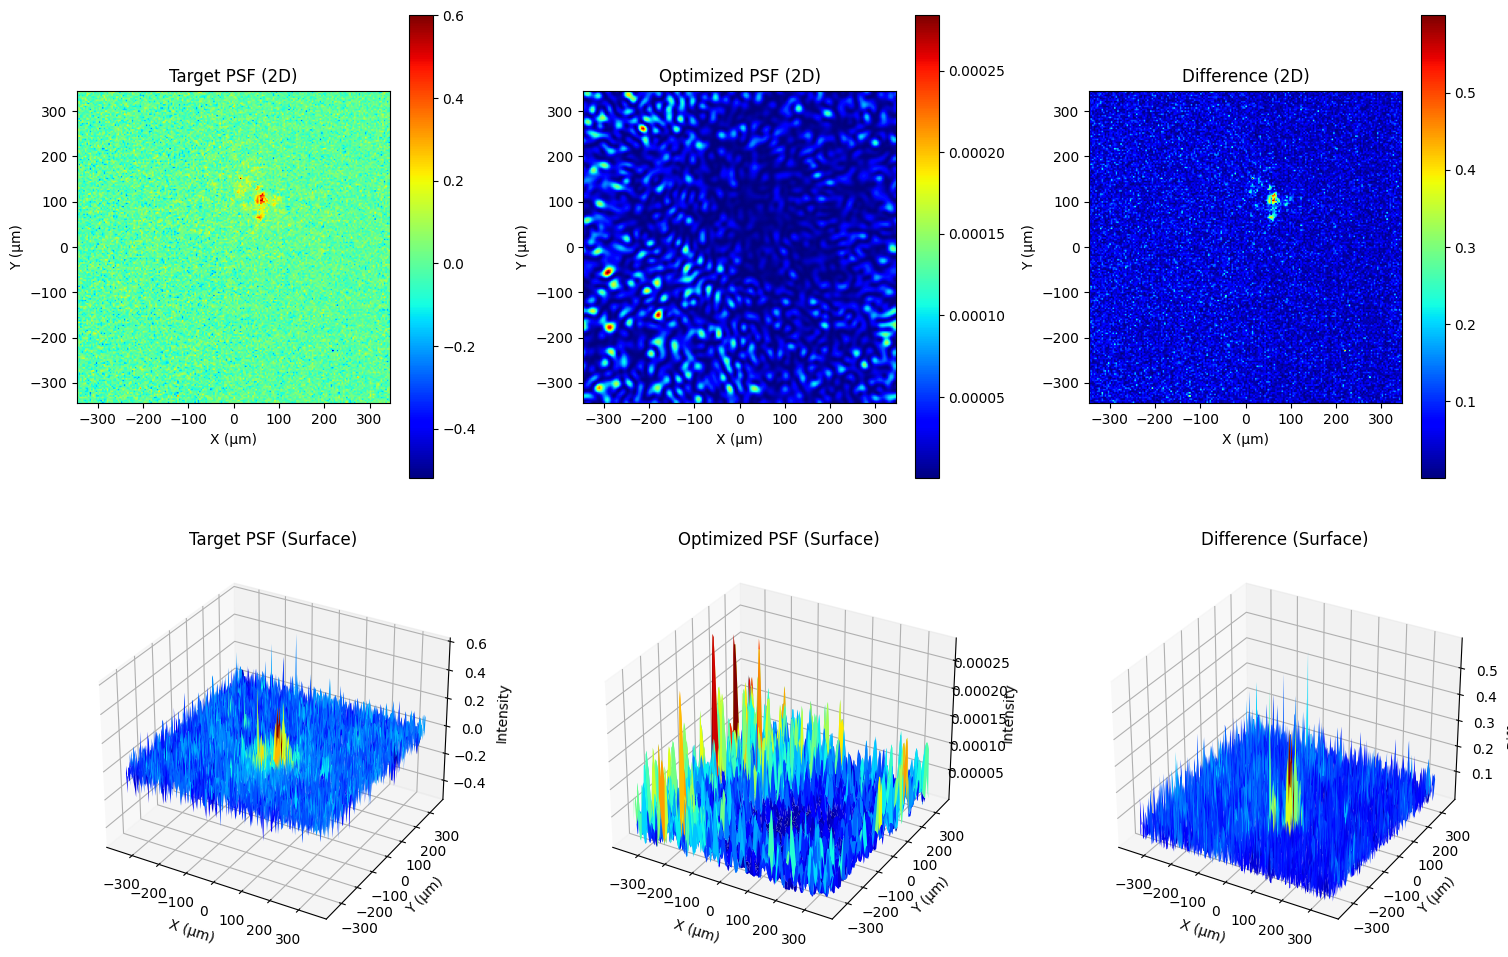

In [41]:
nxy = 200
dx = 3.45e-6
r = 2e-3

mode_indices = np.linspace(2, 22, 21).astype(int)
x0 = np.zeros(21)

sigma0 = 0.1
popsize = 20
opts = {
    'tolfun': 1e-8,
    'tolx': 1e-8,
    'verb_disp': 10,
    'popsize': popsize,
}

es = cma.CMAEvolutionStrategy(x0, sigma0, opts)

fit = np.empty(popsize)
iteration=0
max_iterations=500

while not es.stop() and iteration < max_iterations:
    iteration += 1
    solutions = es.ask()
    
    for i, soln in enumerate(solutions):
        fit[i] = objfunc(soln, target_psf_7, mode_indices, r)
        
    es.tell(solutions, fit)
    es.disp(10)
    
xopt = es.result.xbest
objfuncopt = es.result.fbest

print("\nOptimization Results:")
print(f"Initial guess: {x0}")
print(f"Optimized coefficients: {xopt}")
print(f"Final objective function value: {objfuncopt}")
print(f"Stopping criterion: {es.stop()}")

# Generate the optimized PSF

optimized_psf_7 = make_psf(r, xopt, mode_indices, nxy)

x1, y1, x2, y2 = 625, 375, 825, 575

um_per_pixel = 6.260371216900035e-07
N = 200
size_in_um = N * um_per_pixel
extent = [-size_in_um/2, size_in_um/2, -size_in_um/2, size_in_um/2]

plot_psf_comparison(target_psf_7, optimized_psf_7, extent=extent)

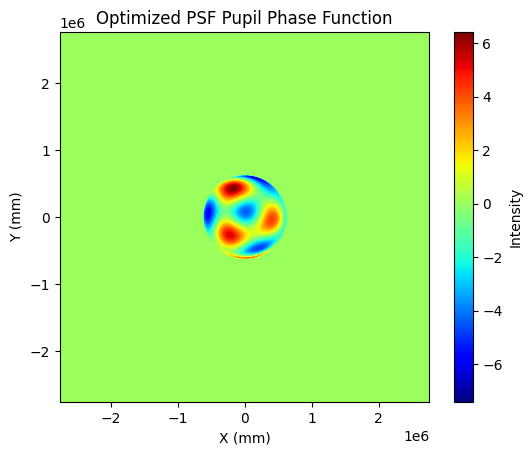

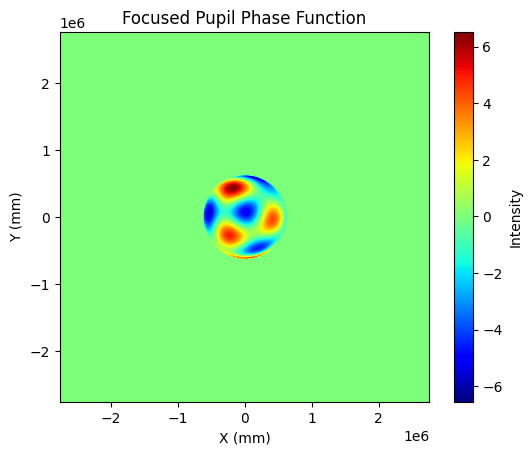

In [42]:
mode_indices = np.linspace(2, 22, 21).astype(int)
xopt = [0.11397126, -0.03730682, -0.42202158,  0.12679589, -0.36705103,  0.05894986, -0.03521042, -0.24473797, -1.55885445, -1.01497093, -0.11606344,  0.27636288, -0.22188093, -0.36480356,  0.12528799, -1.07304955,  0.97534961,  0.70306041, -0.01396791, -0.18949706,  0.81151941]
xopt_focused = [0, 0, 0,  0.12679589, -0.36705103,  0.05894986, -0.03521042, -0.24473797, -1.55885445, -1.01497093, -0.11606344,  0.27636288, -0.22188093, -0.36480356,  0.12528799, -1.07304955,  0.97534961,  0.70306041, -0.01396791, -0.18949706,  0.81151941]

plot_pupil_phase(mode_indices, xopt, r=2e-3, lambd=450e-9, zi=0.13640241886756652, nxy=1001, dx=3.45e-6, title="Optimized PSF Pupil Phase Function")
plot_pupil_phase(mode_indices, xopt_focused, r=2e-3, lambd=450e-9, zi=0.13640241886756652, nxy=1001, dx=3.45e-6, title="Focused Pupil Phase Function")

Focusing the pupil phase function for the blue filter images made much more of a difference than in the green filter images. We can clearly see a difference between negative intensity regions like in the center which are then surrounded by positive intensity regions. These central negative region became larger as the pupil phase function was focused. For the already focused blue filtered image, also made slight changes in the patterns of the pupil phase function, suggesting it was not properly focused or there were difficulties in image aquisition. The latter is clearly seen in the 2D and surface plot of the PSF images, suggesting that better image aquisition would allow for improved optimization and more accurate results. 